In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive montado")


Mounted at /content/drive
✓ Google Drive montado


In [ ]:
import torch
import os

# Buscar el archivo en Drive
# Ajusta la ruta según dónde esté en tu Drive
DATASET_PATH = '/content/drive/MyDrive/kaspix_universal_rack.pt'

# Si está en otra ubicación, usa esto para buscarlo:
print("Buscando dataset...")
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    if 'kaspix_universal_rack.pt' in files:
        DATASET_PATH = os.path.join(root, 'kaspix_universal_rack.pt')
        print(f"✓ Dataset encontrado en: {DATASET_PATH}")
        break

# Cargar dataset
print("\nCargando dataset...")
data = torch.load(DATASET_PATH, weights_only=False)

print(f"✓ Dataset cargado exitosamente")
print(f"  Total muestras: {len(data['x']):,}")
print(f"  Claves: {list(data.keys())}")
print(f"  Tamaño en memoria: ~{DATASET_PATH}")


Buscando dataset...
✓ Dataset encontrado en: /content/drive/MyDrive/kaspix_universal_rack.pt

Cargando dataset...
✓ Dataset cargado exitosamente
  Total muestras: 99,371
  Claves: ['x', 'y', 'meta', 'max_knobs', 'description']
  Tamaño en memoria: ~/content/drive/MyDrive/kaspix_universal_rack.pt


In [ ]:
# Verificar estructura rápida
from collections import Counter

print("📊 VERIFICACIÓN DEL DATASET\n")

# Topologías
topology_counts = Counter([s['topology_id'] for s in data['x']])
print(f"Topologías encontradas: {len(topology_counts)}")
for topo_id, count in sorted(topology_counts.items()):
    print(f"  Topology {topo_id}: {count:,} muestras ({count/len(data['x'])*100:.1f}%)")

# Verificar knobs
sample_0 = data['x'][0]
print(f"\nEjemplo muestra 0:")
print(f"  Audio shape: {sample_0['audio_in'].shape}")
print(f"  Knobs shape: {sample_0['knobs'].shape}")
print(f"  Topology ID: {sample_0['topology_id']}")
print(f"  Nombres knobs: {sample_0.get('original_names', 'No disponible')}")

print("\n✓ Dataset verificado - Listo para entrenar")


📊 VERIFICACIÓN DEL DATASET

Topologías encontradas: 4
  Topology 0: 20,000 muestras (20.1%)
  Topology 1: 20,000 muestras (20.1%)
  Topology 2: 29,371 muestras (29.6%)
  Topology 3: 30,000 muestras (30.2%)

Ejemplo muestra 0:
  Audio shape: (960,)
  Knobs shape: (5,)
  Topology ID: 0
  Nombres knobs: ['R_gain', 'C_cut', 'V_bias']

✓ Dataset verificado - Listo para entrenar


In [ ]:
import numpy as np

print("🔧 ANÁLISIS DETALLADO DE KNOBS POR TOPOLOGÍA\n")

topology_knobs = {}

for sample in data['x']:
    topo_id = sample['topology_id']
    if topo_id not in topology_knobs:
        topology_knobs[topo_id] = {
            'knob_names': sample.get('original_names', []),
            'num_real_knobs': len(sample.get('original_names', [])),
            'example_values': sample['knobs'],
            'knobs_samples': []
        }
    topology_knobs[topo_id]['knobs_samples'].append(sample['knobs'])

print("="*60)
for topo_id in sorted(topology_knobs.keys()):
    info = topology_knobs[topo_id]
    knobs_array = np.array(info['knobs_samples'])

    print(f"\nTopology {topo_id}:")
    print(f"  Knobs reales: {info['num_real_knobs']}")
    print(f"  Nombres: {info['knob_names']}")
    print(f"  Ejemplo valores: {info['example_values']}")
    print(f"\n  Rangos por knob:")

    for i in range(5):
        kmin = knobs_array[:, i].min()
        kmax = knobs_array[:, i].max()
        kmean = knobs_array[:, i].mean()
        kstd = knobs_array[:, i].std()

        # Detectar si es padding (todos ceros o constante)
        is_padding = (kmax - kmin) < 1e-9
        status = "🔴 PADDING" if is_padding else "✅ ACTIVO"

        print(f"    Knob[{i}]: min={kmin:8.4f}, max={kmax:8.4f}, "
              f"mean={kmean:8.4f}, std={kstd:8.4f} {status}")

print("\n" + "="*60)

# VERIFICACIÓN CRÍTICA: Normalización global
print("\n📐 VERIFICACIÓN DE NORMALIZACIÓN GLOBAL")
all_knobs = np.stack([x['knobs'] for x in data['x']])
print(f"\nShape all_knobs: {all_knobs.shape}")

for i in range(5):
    kmin = all_knobs[:, i].min()
    kmax = all_knobs[:, i].max()
    kmean = all_knobs[:, i].mean()

    # Verificar si este knob es usado por alguna topología
    is_used = False
    for topo_info in topology_knobs.values():
        topo_knobs = np.array(topo_info['knobs_samples'])
        if (topo_knobs[:, i].max() - topo_knobs[:, i].min()) > 1e-9:
            is_used = True
            break

    status = "✅ USADO" if is_used else "⚠️ SIEMPRE PADDING"
    print(f"Knob[{i}] global: min={kmin:.4f}, max={kmax:.4f}, mean={kmean:.4f} {status}")

print("\n" + "="*60)
print("\n⚠️ IMPORTANTE PARA NORMALIZACIÓN:")
print("   Si algún knob es 'SIEMPRE PADDING', su normalización será (0-0)/(0-0+eps) = 0")
print("   Esto está bien, no afectará el entrenamiento.")
print("   Los knobs activos se normalizarán correctamente a [0,1]")


🔧 ANÁLISIS DETALLADO DE KNOBS POR TOPOLOGÍA


Topology 0:
  Knobs reales: 3
  Nombres: ['R_gain', 'C_cut', 'V_bias']
  Ejemplo valores: [6.4122812e+03 1.6033449e-07 8.5523367e-01 0.0000000e+00 0.0000000e+00]

  Rangos por knob:
    Knob[0]: min=2000.0996, max=17999.9805, mean=10020.6416, std=4581.0820 ✅ ACTIVO
    Knob[1]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 ✅ ACTIVO
    Knob[2]: min=  0.1001, max=  0.9000, mean=  0.5001, std=  0.2316 ✅ ACTIVO
    Knob[3]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 🔴 PADDING
    Knob[4]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 🔴 PADDING

Topology 1:
  Knobs reales: 3
  Nombres: ['R_gain', 'C_hp', 'R_load']
  Ejemplo valores: [6.4122812e+03 1.6033449e-07 1.7104673e+05 0.0000000e+00 0.0000000e+00]

  Rangos por knob:
    Knob[0]: min=2000.0996, max=17999.9805, mean=10020.6416, std=4581.0820 ✅ ACTIVO
    Knob[1]: min=  0.0000, max=  0.0000, mean=  0.0000, std=  0.0000 ✅ ACTIVO
    Knob[2]: min=20014.9141, m

In [ ]:
# CELDA DE VERIFICACIÓN URGENTE
import numpy as np

print("🚨 VERIFICACIÓN CRÍTICA DE VALORES PEQUEÑOS\n")

# Verificar si realmente hay valores no-cero en Knob[1] y Knob[3]
all_knobs = np.stack([x['knobs'] for x in data['x']])

for knob_idx in [1, 3]:
    values = all_knobs[:, knob_idx]
    non_zero = values[values != 0]

    print(f"Knob[{knob_idx}]:")
    print(f"  Total muestras: {len(values)}")
    print(f"  Valores != 0: {len(non_zero)}")
    print(f"  Min (todos): {values.min():.15e}")
    print(f"  Max (todos): {values.max():.15e}")

    if len(non_zero) > 0:
        print(f"  Min (no-cero): {non_zero.min():.15e}")
        print(f"  Max (no-cero): {non_zero.max():.15e}")
        print(f"  Primeros 5 no-cero: {non_zero[:5]}")
    print()

# Verificar ejemplo específico que mostraste
print("Verificación muestra específica de Topology 1:")
for i, sample in enumerate(data['x']):
    if sample['topology_id'] == 1:
        print(f"  Muestra {i}: knobs = {sample['knobs']}")
        break


🚨 VERIFICACIÓN CRÍTICA DE VALORES PEQUEÑOS

Knob[1]:
  Total muestras: 99371
  Valores != 0: 99371
  Min (todos): 2.000274612612429e-08
  Max (todos): 1.799993185613857e-07
  Min (no-cero): 2.000274612612429e-08
  Max (no-cero): 1.799993185613857e-07
  Primeros 5 no-cero: [1.6033449e-07 1.5569748e-07 9.1176389e-08 3.9353704e-08 8.6900911e-08]

Knob[3]:
  Total muestras: 99371
  Valores != 0: 59371
  Min (todos): 0.000000000000000e+00
  Max (todos): 3.599865578962635e-07
  Min (no-cero): 2.000002830016001e-09
  Max (no-cero): 3.599865578962635e-07
  Primeros 5 no-cero: [1.5761959e-08 9.9822106e-09 1.6997653e-08 1.3350127e-08 1.6042351e-08]

Verificación muestra específica de Topology 1:
  Muestra 20000: knobs = [6.4122812e+03 1.6033449e-07 1.7104673e+05 0.0000000e+00 0.0000000e+00]


In [ ]:
# ============================================================
# CONFIGURACIÓN ESTANDARIZADA DEL BENCHMARK
# ============================================================

BENCHMARK_CONFIG = {
    # Dataset (ya está cargado en 'data')
    'seed': 42,

    # Split (70/15/15)
    'train_ratio': 0.70,
    'val_ratio': 0.15,
    'test_ratio': 0.15,

    # Data loader
    'batch_size': 32,
    'num_workers': 2,
    'pin_memory': True,
    'drop_last': True,

    # Training
    'epochs': 10,
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'gradient_clip': 1.0,

    # Scheduler
    'scheduler_patience': 5,
    'scheduler_factor': 0.5,

    # Model specs (fijos para todas las arquitecturas)
    'input_size': 10,  # 1 audio + 5 knobs + 4 topology
    'num_knobs': 5,
    'num_topologies': 4,
    'output_size': 1,

    # Noise en parámetros y QAT
    'analog_levels': 32,      # Equivalente a 5 bits (Resistencias estándar)
    'noise_std': 0.03,        # 3% de ruido (Tolerancia típica de componentes)

    # Loss
    'criterion': 'MSE',
}

print("✓ Configuración cargada")
print(f"  Seed: {BENCHMARK_CONFIG['seed']}")
print(f"  Split: {BENCHMARK_CONFIG['train_ratio']:.0%}/{BENCHMARK_CONFIG['val_ratio']:.0%}/{BENCHMARK_CONFIG['test_ratio']:.0%}")
print(f"  Batch size: {BENCHMARK_CONFIG['batch_size']}")
print(f"  Epochs: {BENCHMARK_CONFIG['epochs']}")
print(f"  Learning rate: {BENCHMARK_CONFIG['learning_rate']}")


✓ Configuración cargada
  Seed: 42
  Split: 70%/15%/15%
  Batch size: 32
  Epochs: 10
  Learning rate: 0.001


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class UniversalFilterDataset(Dataset):
    """
    Dataset estandarizado para benchmark.
    USAR ESTA MISMA CLASE EN TODAS LAS ARQUITECTURAS.
    """
    def __init__(self, datadict, kmin=None, kmax=None):
        self.xraw = datadict['x']
        self.yraw = datadict['y']
        self.fs = datadict.get('fs', 48000)

        # Specs fijos
        self.num_knobs = len(self.xraw[0]['knobs'])  # Debe ser 5
        self.knob_names = self.xraw[0].get('original_names',
                                           [f'knob{i}' for i in range(self.num_knobs)])
        self.num_topologies = 4

        # Normalización: usar params externos si se proveen
        if kmin is not None and kmax is not None:
            self.kmin = kmin
            self.kmax = kmax
        else:
            # Calcular de todo el dataset (solo para primera vez)
            all_knobs = np.stack([x['knobs'] for x in self.xraw])
            self.kmin = all_knobs.min(0)
            self.kmax = all_knobs.max(0)

        print(f"Dataset: {len(self)} muestras | Input: (T, {1+self.num_knobs+self.num_topologies})")
        print(f"  Normalización knobs:")
        print(f"    kmin: {self.kmin}")
        print(f"    kmax: {self.kmax}")

    def __len__(self):
        return len(self.xraw)

    def __getitem__(self, idx):
        xsample = self.xraw[idx]
        ysample = self.yraw[idx]

        T = len(xsample['audio_in'])

        # Audio
        audio = xsample['audio_in'].astype(np.float32).reshape(T, 1)

        # Knobs normalizados
        knobs_norm = (xsample['knobs'] - self.kmin) / (self.kmax - self.kmin + 1e-10)
        knobs_tiled = np.tile(knobs_norm[None, :], (T, 1))

        # Topology one-hot
        topo_id = int(xsample['topology_id'])
        topo_onehot = np.zeros(self.num_topologies)
        topo_onehot[topo_id] = 1
        topo_tiled = np.tile(topo_onehot[None, :], (T, 1))

        # Concatenar: [audio(1), knobs(5), topology(4)] = 10
        x = np.concatenate([audio, knobs_tiled, topo_tiled], axis=1)

        return torch.FloatTensor(x), torch.FloatTensor(ysample.reshape(T, 1))

print("✓ Dataset class definida")


✓ Dataset class definida


# ***BLOQUE DE RUIDO EN PARÁMETROS Y QUANTIZACIÓN***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AnalogUtils:
    """
    Simula imperfecciones de hardware analógico:
    1. Cuantización (Niveles discretos de conductancia)
    2. Ruido de Peso (Variabilidad térmica/fabricación)
    3. Clipping (Límites de voltaje/conductancia)
    """

    @staticmethod
    def fake_quantize(weights, levels=16, range_limit=1.0):
        """
        Simula la baja resolución de las resistencias programables.
        levels: Cantidad de estados posibles de la resistencia (ej. 16, 32, 64).
        """
        # 1. Clamping: Restringir valores al rango físico [-range, range]
        w_clamped = torch.clamp(weights, -range_limit, range_limit)

        # 2. Escalar al rango de enteros [0, levels-1]
        scale = (levels - 1) / (2 * range_limit)
        w_scaled = (w_clamped + range_limit) * scale

        # 3. Redondear (Simular la discretización) - Usamos .detach() para el round
        # pero mantenemos el gradiente fluyendo (Straight Through Estimator)
        w_rounded = (w_scaled.round() - w_scaled).detach() + w_scaled

        # 4. Des-escalar de vuelta al rango original
        w_quant = (w_rounded / scale) - range_limit
        return w_quant

    @staticmethod
    def inject_noise(weights, std_dev=0.02):
        """
        Agrega ruido gaussiano a los pesos para simular deriva térmica y ruido de lectura.
        std_dev: 0.02 significa 2% de ruido respecto a la escala unitaria.
        """
        noise = torch.randn_like(weights) * std_dev
        return weights + noise

class AnalogLinear(nn.Linear):
    """
    Una capa Linear (Densa) que se comporta como un Crossbar Array analógico.
    Reemplaza nn.Linear con esto.
    """
    def __init__(self, in_features, out_features, bias=True,
                 analog_levels=32, noise_std=0.02):
        super(AnalogLinear, self).__init__(in_features, out_features, bias)
        self.analog_levels = analog_levels
        self.noise_std = noise_std
        self.training_mode = True # Flag para activar/desactivar efectos

    def forward(self, input):
        # 1. Copiamos los pesos originales
        w_simulated = self.weight

        # 2. Aplicamos Cuantización (Si estamos entrenando o validando en modo hardware)
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        # 3. Aplicamos Ruido (Solo si training_mode es True)
        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        # 4. Operación Lineal usando los pesos "sucios"
        # F.linear usa (input, weight, bias)
        return F.linear(input, w_simulated, self.bias)

class AnalogConv1d(nn.Conv1d):
    """
    Versión analógica de Conv1d.
    Simula que los filtros de convolución están almacenados en memristores/resistencias.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True,
                 padding_mode='zeros', device=None, dtype=None,
                 analog_levels=32, noise_std=0.02):

        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups, bias, padding_mode, device, dtype)

        self.analog_levels = analog_levels
        self.noise_std = noise_std

    def forward(self, input):
        # 1. Copiamos pesos
        w_simulated = self.weight

        # 2. Cuantización (Simular resolución finita)
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        # 3. Inyección de Ruido (Solo en training)
        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        # 4. Convolución usando F.conv1d con los pesos sucios
        return nn.functional.conv1d(input, w_simulated, self.bias, self.stride,
                                    self.padding, self.dilation, self.groups)

print("✓ Capa AnalogConv1d definida")

✓ Capa AnalogConv1d definida


# ***LSTM***

In [ ]:
# --- CORRECCIÓN: Imports SIEMPRE arriba del todo ---
import torch
import torch.nn as nn
import torch.nn.functional as F

# Si tu versión de PyTorch es reciente (2.0+), usa esto:
try:
    from torch.func import functional_call
except ImportError:
    # Fallback para versiones viejas (Colab a veces tiene versiones mixtas)
    from torch.nn.utils.stateless import functional_call

class AnalogLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1,
                 analog_levels=32, noise_std=0.02):
        super(AnalogLSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.noise_std = noise_std

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = AnalogLinear(hidden_size, output_size,
                               analog_levels=analog_levels,
                               noise_std=noise_std)

    def forward(self, x):
        # 1. Usamos torch global (ya no dará error aquí)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # --- LÓGICA STATELESS ---
        if self.training and self.noise_std > 0:
            noisy_params = {}
            for name, param in self.lstm.named_parameters():
                noise = torch.randn_like(param) * self.noise_std
                noisy_params[name] = param + noise

            # Usamos la función importada arriba
            out, _ = functional_call(self.lstm, noisy_params, (x, (h0, c0)))
        else:
            out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out)
        return out

print("✓ Modelo LSTM Corregido (Imports arreglados)")


print("✓ Modelo LSTM analógico definido")


✓ Modelo LSTM Corregido (Imports arreglados)
✓ Modelo LSTM analógico definido


In [ ]:
import torch.optim as optim

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(),
                                       BENCHMARK_CONFIG['gradient_clip'])
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def val_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += criterion(pred, y).item()

    return total_loss / len(loader)

def compute_metrics(model, loader, device):
    """Métricas estandarizadas para benchmark"""
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Métricas
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # R²
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2)
    }

print("✓ Funciones de entrenamiento definidas")


✓ Funciones de entrenamiento definidas


In [ ]:
from torch.utils.data import DataLoader, random_split

# Reproducibilidad
torch.manual_seed(BENCHMARK_CONFIG['seed'])
np.random.seed(BENCHMARK_CONFIG['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Crear dataset (data ya está cargado)
print("1️⃣ Creando dataset...")
dataset = UniversalFilterDataset(data)

# Split con seed fijo
print(f"\n2️⃣ Creando split (seed={BENCHMARK_CONFIG['seed']})...")
total = len(dataset)
train_size = int(BENCHMARK_CONFIG['train_ratio'] * total)
val_size = int(BENCHMARK_CONFIG['val_ratio'] * total)
test_size = total - train_size - val_size

trainds, valds, testds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(BENCHMARK_CONFIG['seed'])
)

print(f"   Train: {len(trainds):,} | Val: {len(valds):,} | Test: {len(testds):,}")

# IMPORTANTE: Guardar indices del split para reproducibilidad
split_indices = {
    'train': trainds.indices,
    'val': valds.indices,
    'test': testds.indices
}
torch.save(split_indices, 'benchmark_split_indices.pt')
print(f"   ✓ Índices guardados en: benchmark_split_indices.pt")

# Data loaders
print(f"\n3️⃣ Creando data loaders...")
train_loader = DataLoader(
    trainds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=True,
    num_workers=BENCHMARK_CONFIG['num_workers'],
    pin_memory=BENCHMARK_CONFIG['pin_memory'],
    drop_last=BENCHMARK_CONFIG['drop_last']
)

val_loader = DataLoader(
    valds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

test_loader = DataLoader(
    testds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

print(f"   Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")


Device: cuda

1️⃣ Creando dataset...
Dataset: 99371 muestras | Input: (T, 10)
  Normalización knobs:
    kmin: [2.00000793e+03 2.00027461e-08 1.00074574e-01 0.00000000e+00
 0.00000000e+00]
    kmax: [1.7999992e+04 1.7999932e-07 1.7999923e+05 3.5998656e-07 1.7999825e+05]

2️⃣ Creando split (seed=42)...
   Train: 69,559 | Val: 14,905 | Test: 14,907
   ✓ Índices guardados en: benchmark_split_indices.pt

3️⃣ Creando data loaders...
   Batches - Train: 2173 | Val: 466 | Test: 466


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import copy
from torch.nn.utils import stateless # Para inyección de ruido limpia

# --- CONFIGURACIÓN DEL ESTUDIO ---
STUDY_CONFIG = {
    # Eje Y: Niveles de ruido con los que se ENTRENARON los modelos
    'train_sigmas': [0.0, 0.01, 0.02, 0.04, 0.07, 0.1],

    # Eje X: Niveles de ruido que simularán el HARDWARE en inferencia
    'infer_sigmas': [0.0, 0.01, 0.02, 0.04, 0.07, 0.1],

    'base_config': BENCHMARK_CONFIG, # Tu config base (lr, batch_size, etc)
    'device': device
}

In [ ]:
def train_variant(sigma_train, train_loader, val_loader, config):
    print(f"\n>>> Entrenando Variante: Train Sigma = {sigma_train}")

    # 1. Instanciar Modelo con el ruido de entrenamiento específico
    model = AnalogLSTMModel(
        input_size=config['base_config']['input_size'],
        hidden_size=128,
        output_size=1,
        num_layers=2,
        analog_levels=32,       # Mantenemos cuantización fija
        noise_std=sigma_train   # <--- AQUI SE DEFINE EL RUIDO DE ENTRENAMIENTO
    ).to(config['device'])

    # 2. Setup standard
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['base_config']['learning_rate'])

    # 3. Loop de entrenamiento simplificado (Early stopping básico)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config['base_config']['epochs']):
        model.train() # Activa el ruido interno definido en __init__
        epoch_loss = 0

        for batch in train_loader:
            # Asumiendo que tu loader entrega [audio, knobs, ids, target]
            # CORRECCIÓN: el dataset devuelve (x, y), así que y está en batch[1]
            x, target = batch[0].to(config['device']), batch[1].to(config['device'])

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validación simple
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                # CORRECCIÓN: el dataset devuelve (x, y), así que y está en batch[1]
                x, target = batch[0].to(config['device']), batch[1].to(config['device'])
                # NOTA: En validación estándar NO hay ruido (model.eval apaga el flag)
                out = model(x)
                val_loss += criterion(out, target).item()

        avg_val_loss = val_loss / len(val_loader)

        # Guardar mejor
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), f'lstm_sigma_{sigma_train}.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > 5: break # Early stopping rápido para el estudio

    print(f"   ✓ Terminado. Best Val Loss (Clean): {best_loss:.5f}")
    return f'lstm_sigma_{sigma_train}.pt'

In [ ]:
def evaluate_variant_with_noise(model_path, infer_sigma, test_loader, device):
    # 1. Cargar la arquitectura limpia
    # Inicializamos con noise_std=0 porque controlaremos el ruido manualmente aquí
    model = AnalogLSTMModel(
        input_size=STUDY_CONFIG['base_config']['input_size'],
        hidden_size=128, output_size=1, num_layers=2, noise_std=0.0
    ).to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval() # IMPORTANTE: Apaga Dropout y Batchnorm updates

    criterion = nn.MSELoss()
    total_loss = 0
    steps = 0

    # 2. Loop de prueba
    with torch.no_grad():
        for batch in test_loader:
            # CORRECCIÓN: el dataset devuelve (x, y), así que y está en batch[1]
            x, target = batch[0].to(device), batch[1].to(device)

            # --- INYECCIÓN DE RUIDO EN TIEMPO DE INFERENCIA ---
            if infer_sigma > 0:
                # Generamos un diccionario de parámetros "sucios"
                noisy_params = {}
                for name, param in model.named_parameters():
                    noise = torch.randn_like(param) * infer_sigma
                    noisy_params[name] = param + noise

                # Ejecutamos el modelo usando los pesos sucios (STATELESS CALL)
                # Esto omite los pesos internos y usa los que pasamos
                out = torch.func.functional_call(model, noisy_params, (x,))
            else:
                # Inferencia limpia (Hardware ideal)
                out = model(x)

            loss = criterion(out, target)
            total_loss += loss.item()
            steps += 1

    return total_loss / steps

In [ ]:
results_matrix = []

# PASO A: Entrenar los 5 modelos (Eje Y)
model_files = {}
print("--- FASE 1: ENTRENAMIENTO MULTI-SIGMA ---")
for sigma_train in STUDY_CONFIG['train_sigmas']:
    filename = train_variant(sigma_train, train_loader, val_loader, STUDY_CONFIG)
    model_files[sigma_train] = filename

# PASO B: Cruzar cada modelo con los 5 niveles de ruido de hardware (Eje X)
print("\n--- FASE 2: CROSS-EVALUATION (5x5) ---")
for train_sigma in STUDY_CONFIG['train_sigmas']:

    current_model_file = model_files[train_sigma]

    for infer_sigma in STUDY_CONFIG['infer_sigmas']:
        mse = evaluate_variant_with_noise(
            current_model_file,
            infer_sigma,
            test_loader,
            device
        )

        print(f"Model(Train={train_sigma}) vs Hardware(Infer={infer_sigma}) -> MSE: {mse:.6f}")

        results_matrix.append({
            'Train_Noise_Std': train_sigma,
            'Inference_Noise_Std': infer_sigma,
            'MSE_Loss': mse
        })

# Crear DataFrame Final
df_results = pd.DataFrame(results_matrix)
print("\n✓ Estudio Completado.")

--- FASE 1: ENTRENAMIENTO MULTI-SIGMA ---

>>> Entrenando Variante: Train Sigma = 0.0


KeyboardInterrupt: 

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-328354499.py:22: SyntaxWarning: invalid escape sequence '\s'
  label=f'Train $\sigma$={t_sigma}'
/tmp/ipython-input-328354499.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Inference Hardware Noise ($\sigma$)', fontsize=12)


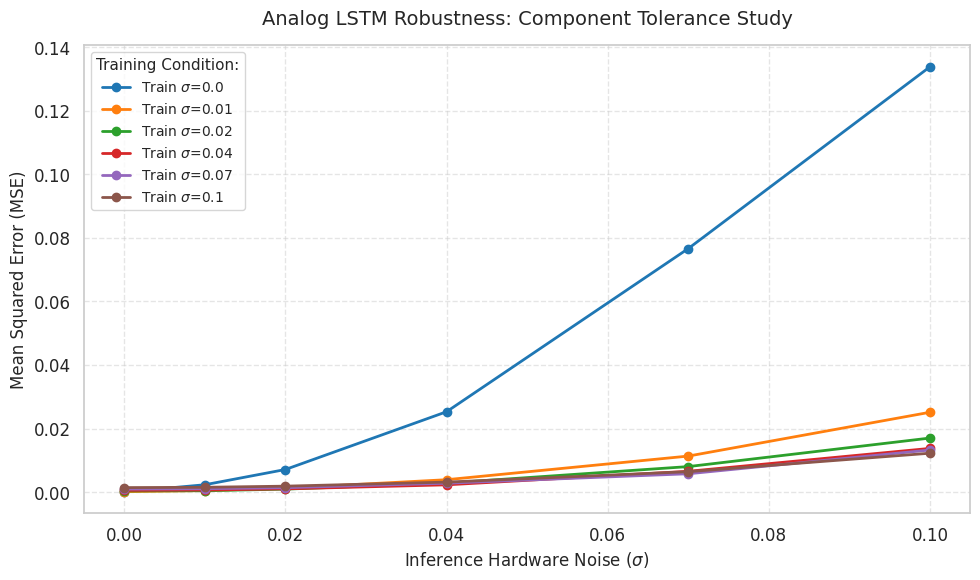

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_robustness_study(df):
    # Configuración de estilo visual (opcional, para que se vea más académico)
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))

    # Each line represents a model trained with different noise levels
    train_sigmas = df['Train_Noise_Std'].unique()

    for t_sigma in train_sigmas:
        subset = df[df['Train_Noise_Std'] == t_sigma]
        plt.plot(
            subset['Inference_Noise_Std'],
            subset['MSE_Loss'],
            marker='o',
            linewidth=2,
            # Label para la leyenda
            label=f'Train $\sigma$={t_sigma}'
        )

    # --- TRANSLATION TO ENGLISH ---
    plt.title('Analog LSTM Robustness: Component Tolerance Study', fontsize=14, pad=15)
    plt.xlabel('Inference Hardware Noise ($\sigma$)', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)

    plt.legend(title="Training Condition:", fontsize=10, title_fontsize=11)

    plt.grid(True, linestyle='--', alpha=0.5, which='both')

    # Log scale is crucial to see the orders of magnitude difference
    # plt.yscale('log')

    plt.tight_layout()
    plt.show()

# Ejecutar la función
plot_robustness_study(df_results)

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2145773281.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Training Noise ($\sigma$)')
/tmp/ipython-input-2145773281.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Inference Hardware Noise ($\sigma$)')


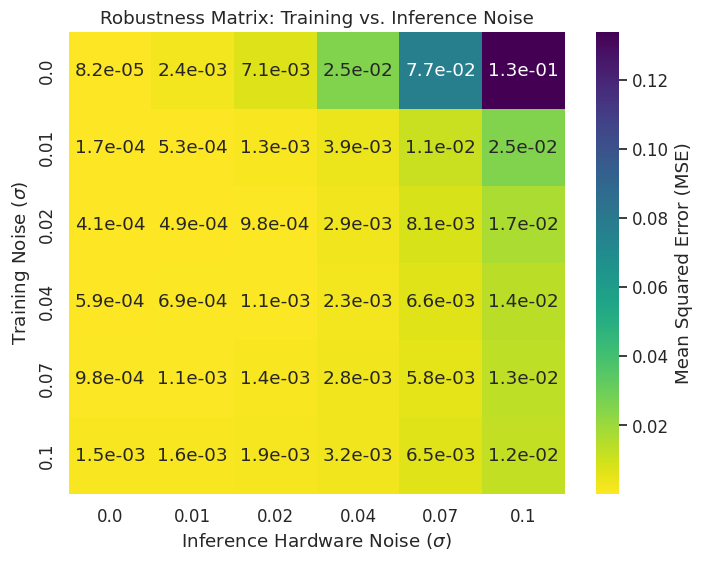

In [ ]:
def plot_robustness_heatmap(df):
    # Pivotar la tabla para formato matriz
    pivot_table = df.pivot(
        index='Train_Noise_Std',
        columns='Inference_Noise_Std',
        values='MSE_Loss'
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pivot_table,
        annot=True,      # Mostrar números
        fmt=".1e",       # Notación científica (ej. 1.2e-3)
        cmap="viridis_r", # 'r' invierte para que colores oscuros sean menos error (mejor)
        cbar_kws={'label': 'Mean Squared Error (MSE)'}
    )

    plt.title('Robustness Matrix: Training vs. Inference Noise')
    plt.ylabel('Training Noise ($\sigma$)')
    plt.xlabel('Inference Hardware Noise ($\sigma$)')
    plt.show()

plot_robustness_heatmap(df_results)

# ***RNN***

In [ ]:
# ============================================================
# SETUP INICIAL - PREPARACIÓN DE DATOS Y DEVICE
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset

# --- CONFIGURACIÓN BASE ---
BENCHMARK_CONFIG = {
    'seed': 42,
    'train_ratio': 0.70,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'batch_size': 32,
    'num_workers': 2,
    'pin_memory': True,
    'drop_last': True,
    'epochs': 10,
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'gradient_clip': 1.0,
    'input_size': 10,
    'num_knobs': 5,
    'num_topologies': 4,
    'output_size': 1,
    'criterion': 'MSE',
}

# Reproducibilidad
torch.manual_seed(BENCHMARK_CONFIG['seed'])
np.random.seed(BENCHMARK_CONFIG['seed'])

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# --- DATASET CLASS ---
class UniversalFilterDataset(Dataset):
    """Dataset estandarizado para benchmark"""
    def __init__(self, datadict, kmin=None, kmax=None):
        self.xraw = datadict['x']
        self.yraw = datadict['y']
        self.fs = datadict.get('fs', 48000)

        self.num_knobs = len(self.xraw[0]['knobs'])
        self.knob_names = self.xraw[0].get('original_names',
                                           [f'knob{i}' for i in range(self.num_knobs)])
        self.num_topologies = 4

        if kmin is not None and kmax is not None:
            self.kmin = kmin
            self.kmax = kmax
        else:
            all_knobs = np.stack([x['knobs'] for x in self.xraw])
            self.kmin = all_knobs.min(0)
            self.kmax = all_knobs.max(0)

        print(f"Dataset: {len(self)} muestras | Input: (T, {1+self.num_knobs+self.num_topologies})")

    def __len__(self):
        return len(self.xraw)

    def __getitem__(self, idx):
        xsample = self.xraw[idx]
        ysample = self.yraw[idx]

        T = len(xsample['audio_in'])

        audio = xsample['audio_in'].astype(np.float32).reshape(T, 1)
        knobs_norm = (xsample['knobs'] - self.kmin) / (self.kmax - self.kmin + 1e-10)
        knobs_tiled = np.tile(knobs_norm[None, :], (T, 1))

        topo_id = int(xsample['topology_id'])
        topo_onehot = np.zeros(self.num_topologies)
        topo_onehot[topo_id] = 1
        topo_tiled = np.tile(topo_onehot[None, :], (T, 1))

        x = np.concatenate([audio, knobs_tiled, topo_tiled], axis=1)

        return torch.FloatTensor(x), torch.FloatTensor(ysample.reshape(T, 1))

print("✓ Dataset class definida")

# --- PREPARAR DATA LOADERS ---
print("\n1️⃣ Creando dataset...")
dataset = UniversalFilterDataset(data)

print(f"\n2️⃣ Cargando MISMO split que LSTM...")
# Cargar índices del entrenamiento LSTM
split_indices = torch.load('benchmark_split_indices.pt')

print(f"  ✓ IMPORTANTE: Usando EXACTAMENTE los mismos datos que LSTM")
print(f"  Train indices: {len(split_indices['train'])} muestras")
print(f"  Val indices: {len(split_indices['val'])} muestras")
print(f"  Test indices: {len(split_indices['test'])} muestras")

# Crear subsets con los MISMOS índices
trainds = Subset(dataset, split_indices['train'])
valds = Subset(dataset, split_indices['val'])
testds = Subset(dataset, split_indices['test'])

print(f"  Train: {len(trainds):,} | Val: {len(valds):,} | Test: {len(testds):,}")

# Data loaders
print(f"\n3️⃣ Creando data loaders...")
train_loader = DataLoader(
    trainds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=True,
    num_workers=BENCHMARK_CONFIG['num_workers'],
    pin_memory=BENCHMARK_CONFIG['pin_memory'],
    drop_last=BENCHMARK_CONFIG['drop_last']
)

val_loader = DataLoader(
    valds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

test_loader = DataLoader(
    testds,
    batch_size=BENCHMARK_CONFIG['batch_size'],
    shuffle=False,
    num_workers=BENCHMARK_CONFIG['num_workers']
)

print(f"  Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

# ============================================================
# AHORA SÍ - CAPAS ANALÓGICAS Y MODELO RNN
# ============================================================

class AnalogUtils:
    """Simula imperfecciones de hardware analógico"""

    @staticmethod
    def fake_quantize(weights, levels=16, range_limit=1.0):
        w_clamped = torch.clamp(weights, -range_limit, range_limit)
        scale = (levels - 1) / (2 * range_limit)
        w_scaled = (w_clamped + range_limit) * scale
        w_rounded = (w_scaled.round() - w_scaled).detach() + w_scaled
        w_quant = (w_rounded / scale) - range_limit
        return w_quant

    @staticmethod
    def inject_noise(weights, std_dev=0.02):
        noise = torch.randn_like(weights) * std_dev
        return weights + noise

class AnalogLinear(nn.Linear):
    """Capa Linear que simula Crossbar Array analógico"""
    def __init__(self, in_features, out_features, bias=True,
                 analog_levels=32, noise_std=0.02):
        super(AnalogLinear, self).__init__(in_features, out_features, bias)
        self.analog_levels = analog_levels
        self.noise_std = noise_std

    def forward(self, input):
        w_simulated = self.weight
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        return nn.functional.linear(input, w_simulated, self.bias)

class AnalogRNNModel(nn.Module):
    """RNN con Context MLP adaptada para hardware analógico"""
    def __init__(self, input_size=10, hidden_size=256, num_layers=3,
                 context_dims=[64, 32], analog_levels=32, noise_std=0.02):
        super(AnalogRNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.noise_std = noise_std

        # Context MLP (procesa knobs + topology)
        num_control = input_size - 1
        context_layers = []
        prev_dim = num_control
        for dim in context_dims:
            context_layers.append(AnalogLinear(prev_dim, dim,
                                              analog_levels=analog_levels,
                                              noise_std=noise_std))
            context_layers.append(nn.Tanh())
            prev_dim = dim
        self.context_mlp = nn.Sequential(*context_layers)

        # RNN vanilla
        rnn_input_size = 1 + context_dims[-1]
        self.rnn = nn.RNN(rnn_input_size, hidden_size, num_layers,
                         batch_first=True, nonlinearity='tanh')

        # Output head
        self.output = AnalogLinear(hidden_size, 1,
                                   analog_levels=analog_levels,
                                   noise_std=noise_std)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        audio = x[:, :, 0:1]
        control = x[:, :, 1:]

        context = self.context_mlp(control[:, 0, :])
        context_tiled = context.unsqueeze(1).repeat(1, seq_len, 1)

        rnn_input = torch.cat([audio, context_tiled], dim=2)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        if self.training and self.noise_std > 0:
            noisy_params = {}
            for name, param in self.rnn.named_parameters():
                noise = torch.randn_like(param) * self.noise_std
                noisy_params[name] = param + noise

            try:
                from torch.func import functional_call
            except ImportError:
                from torch.nn.utils.stateless import functional_call

            out, _ = functional_call(self.rnn, noisy_params, (rnn_input, h0))
        else:
            out, _ = self.rnn(rnn_input, h0)

        out = self.output(out)
        return out

print("✓ Modelo RNN analógico definido")

# --- FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN ---
def train_variant(sigma_train, train_loader, val_loader, config):
    """Entrena una variante con sigma_train específico"""
    print(f"\n>>> Entrenando Variante: Train Sigma = {sigma_train}")

    model = AnalogRNNModel(
        input_size=config['base_config']['input_size'],
        hidden_size=256,
        num_layers=3,
        context_dims=[64, 32],
        analog_levels=32,
        noise_std=sigma_train
    ).to(config['device'])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['base_config']['learning_rate'])

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config['base_config']['epochs']):
        model.train()
        epoch_loss = 0
        for x, target in train_loader:
            x, target = x.to(config['device']), target.to(config['device'])

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, target in val_loader:
                x, target = x.to(config['device']), target.to(config['device'])
                out = model(x)
                val_loss += criterion(out, target).item()

        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), f'rnn_sigma_{sigma_train}.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > 5:
                break

    print(f"  ✓ Terminado. Best Val Loss (Clean): {best_loss:.5f}")
    return f'rnn_sigma_{sigma_train}.pt'

def evaluate_variant_with_noise(model_path, infer_sigma, test_loader, device):
    """Evalúa modelo con ruido de hardware en inferencia"""
    model = AnalogRNNModel(
        input_size=BENCHMARK_CONFIG['input_size'],
        hidden_size=256,
        num_layers=3,
        context_dims=[64, 32],
        noise_std=0.0
    ).to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    criterion = nn.MSELoss()
    total_loss = 0
    steps = 0

    with torch.no_grad():
        for x, target in test_loader:
            x, target = x.to(device), target.to(device)

            if infer_sigma > 0:
                noisy_params = {}
                for name, param in model.named_parameters():
                    noise = torch.randn_like(param) * infer_sigma
                    noisy_params[name] = param + noise

                try:
                    from torch.func import functional_call
                except ImportError:
                    from torch.nn.utils.stateless import functional_call

                out = functional_call(model, noisy_params, (x,))
            else:
                out = model(x)

            loss = criterion(out, target)
            total_loss += loss.item()
            steps += 1

    return total_loss / steps

# --- CONFIGURACIÓN DEL ESTUDIO ---
STUDY_CONFIG = {
    'train_sigmas': [0.0, 0.01, 0.02, 0.04, 0.07, 0.1],
    'infer_sigmas': [0.0, 0.01, 0.02, 0.04, 0.07, 0.1],
    'base_config': BENCHMARK_CONFIG,
    'device': device
}

print("\n✓ Configuración del estudio cargada")
print(f"  Train sigmas: {STUDY_CONFIG['train_sigmas']}")
print(f"  Infer sigmas: {STUDY_CONFIG['infer_sigmas']}")

# --- EJECUTAR ESTUDIO ---
results_matrix = []
model_files = {}

print("\n" + "="*60)
print("FASE 1: ENTRENAMIENTO MULTI-SIGMA (RNN)")
print("="*60)

for sigma_train in STUDY_CONFIG['train_sigmas']:
    filename = train_variant(sigma_train, train_loader, val_loader, STUDY_CONFIG)
    model_files[sigma_train] = filename

print("\n" + "="*60)
print("FASE 2: CROSS-EVALUATION (6x6)")
print("="*60)

for train_sigma in STUDY_CONFIG['train_sigmas']:
    current_model_file = model_files[train_sigma]

    for infer_sigma in STUDY_CONFIG['infer_sigmas']:
        mse = evaluate_variant_with_noise(
            current_model_file,
            infer_sigma,
            test_loader,
            device
        )

        print(f"Model(Train={train_sigma}) vs Hardware(Infer={infer_sigma}) -> MSE: {mse:.6f}")

        results_matrix.append({
            'Train_Noise_Std': train_sigma,
            'Inference_Noise_Std': infer_sigma,
            'MSE_Loss': mse
        })

df_results = pd.DataFrame(results_matrix)
print("\n✓ Estudio Completado.")

# --- VISUALIZACIÓN ---
def plot_robustness_study_rnn(df):
    sns.set_context("notebook", font_scale=1.1)
    sns.set_style("whitegrid")

    plt.figure(figsize=(10, 6))

    train_sigmas = df['Train_Noise_Std'].unique()

    for t_sigma in train_sigmas:
        subset = df[df['Train_Noise_Std'] == t_sigma]
        plt.plot(
            subset['Inference_Noise_Std'],
            subset['MSE_Loss'],
            marker='o',
            linewidth=2,
            label=f'Train $\\sigma$={t_sigma}'
        )

    plt.title('Analog RNN Robustness: Component Tolerance Study', fontsize=14, pad=15)
    plt.xlabel('Inference Hardware Noise ($\\sigma$)', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.legend(title='Training Noise', fontsize=10, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()

    plt.savefig('rnn_robustness_study.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Gráfica guardada: rnn_robustness_study.png")

plot_robustness_study_rnn(df_results)

# Guardar resultados
df_results.to_csv('rnn_noise_study_results.csv', index=False)
torch.save({
    'results': df_results.to_dict(),
    'config': STUDY_CONFIG,
}, 'rnn_noise_study_complete.pt')

print("\n✓ Archivos guardados:")
print("  - rnn_noise_study_results.csv")
print("  - rnn_noise_study_complete.pt")
print("  - rnn_robustness_study.png")


Device: cuda

✓ Dataset class definida

1️⃣ Creando dataset...
Dataset: 99371 muestras | Input: (T, 10)

2️⃣ Cargando MISMO split que LSTM...
  ✓ IMPORTANTE: Usando EXACTAMENTE los mismos datos que LSTM
  Train indices: 69559 muestras
  Val indices: 14905 muestras
  Test indices: 14907 muestras
  Train: 69,559 | Val: 14,905 | Test: 14,907

3️⃣ Creando data loaders...
  Batches - Train: 2173 | Val: 466 | Test: 466
✓ Modelo RNN analógico definido

✓ Configuración del estudio cargada
  Train sigmas: [0.0, 0.01, 0.02, 0.04, 0.07, 0.1]
  Infer sigmas: [0.0, 0.01, 0.02, 0.04, 0.07, 0.1]

FASE 1: ENTRENAMIENTO MULTI-SIGMA (RNN)

>>> Entrenando Variante: Train Sigma = 0.0
  ✓ Terminado. Best Val Loss (Clean): 0.01381

>>> Entrenando Variante: Train Sigma = 0.01
  ✓ Terminado. Best Val Loss (Clean): 0.02719

>>> Entrenando Variante: Train Sigma = 0.02
  ✓ Terminado. Best Val Loss (Clean): 0.02534

>>> Entrenando Variante: Train Sigma = 0.04
  ✓ Terminado. Best Val Loss (Clean): 0.04652

>>> Ent

FileNotFoundError: [Errno 2] No such file or directory: 'rnn_sigma_0.1.pt'

In [ ]:
# ============================================================
# ENTRENAR SOLO SIGMA = 0.1 (el que divergió)
# ============================================================

print("="*60)
print("REENTRENANDO: Train Sigma = 0.1")
print("="*60)

# Intentar con learning rate más bajo para evitar divergencia
model_01 = AnalogRNNModel(
    input_size=BENCHMARK_CONFIG['input_size'],
    hidden_size=256,
    num_layers=3,
    context_dims=[64, 32],
    analog_levels=32,
    noise_std=0.1  # Ruido alto
).to(device)

criterion = nn.MSELoss()
# Learning rate REDUCIDO para evitar divergencia
optimizer = optim.Adam(model_01.parameters(), lr=1e-4)  # 10x más bajo

best_loss = float('inf')
patience_counter = 0
diverged = False

print(f"  → Learning rate reducido: 1e-4 (vs 1e-3 normal)")
print(f"  → Ruido de entrenamiento: σ=0.1")

for epoch in range(BENCHMARK_CONFIG['epochs']):
    model_01.train()
    epoch_loss = 0
    n_batches = 0

    for x, target in train_loader:
        x, target = x.to(device), target.to(device)

        optimizer.zero_grad()
        out = model_01(x)
        loss = criterion(out, target)

        # Detectar divergencia
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"  ❌ Divergencia en epoch {epoch}, batch {n_batches}")
            diverged = True
            break

        loss.backward()

        # Gradient clipping más agresivo
        torch.nn.utils.clip_grad_norm_(model_01.parameters(), 0.5)

        optimizer.step()
        epoch_loss += loss.item()
        n_batches += 1

    if diverged:
        print(f"  ❌ MODELO DIVERGIÓ - Ruido σ=0.1 demasiado alto")
        break

    # Validation
    model_01.eval()
    val_loss = 0
    with torch.no_grad():
        for x, target in val_loader:
            x, target = x.to(device), target.to(device)
            out = model_01(x)
            val_loss += criterion(out, target).item()

    avg_train_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"  Epoch {epoch+1}: Train={avg_train_loss:.5f}, Val={avg_val_loss:.5f}")

    # Guardar mejor modelo
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model_01.state_dict(), 'rnn_sigma_0.1.pt')
        patience_counter = 0
        print(f"    💾 Guardado (mejor val loss)")
    else:
        patience_counter += 1
        if patience_counter > 5:
            print(f"    ⏹ Early stopping")
            break

if not diverged and best_loss != float('inf'):
    print(f"\n✓ Entrenamiento exitoso!")
    print(f"  Best Val Loss: {best_loss:.5f}")

    # Agregar a model_files
    model_files[0.1] = 'rnn_sigma_0.1.pt'

    # Evaluar con todos los niveles de ruido de inferencia
    print(f"\n  Evaluando en test set...")
    for infer_sigma in STUDY_CONFIG['infer_sigmas']:
        mse = evaluate_variant_with_noise(
            'rnn_sigma_0.1.pt',
            infer_sigma,
            test_loader,
            device
        )
        print(f"    Hardware(Infer={infer_sigma}) -> MSE: {mse:.6f}")

        # Agregar a results_matrix
        results_matrix.append({
            'Train_Noise_Std': 0.1,
            'Inference_Noise_Std': infer_sigma,
            'MSE_Loss': mse,
            'Diverged': False
        })

    # Actualizar DataFrame
    df_results = pd.DataFrame(results_matrix)

    print(f"\n✓ Modelo σ=0.1 completado y evaluado")
else:
    print(f"\n❌ Modelo σ=0.1 no pudo entrenarse (ruido muy alto)")
    print(f"   → RNN es más sensible que LSTM al ruido de entrenamiento")

    # Marcar como divergido
    for infer_sigma in STUDY_CONFIG['infer_sigmas']:
        results_matrix.append({
            'Train_Noise_Std': 0.1,
            'Inference_Noise_Std': infer_sigma,
            'MSE_Loss': np.nan,
            'Diverged': True
        })

    df_results = pd.DataFrame(results_matrix)

# Guardar resultados actualizados
df_results.to_csv('rnn_noise_study_results.csv', index=False)
torch.save({
    'results': df_results.to_dict(),
    'config': STUDY_CONFIG,
    'model_files': model_files,
}, 'rnn_noise_study_complete.pt')

print(f"\n✓ Resultados actualizados y guardados")
print(f"  Modelos entrenados: {len(model_files)}/6")


REENTRENANDO: Train Sigma = 0.1
  → Learning rate reducido: 1e-4 (vs 1e-3 normal)
  → Ruido de entrenamiento: σ=0.1
  ❌ Divergencia en epoch 0, batch 60
  ❌ MODELO DIVERGIÓ - Ruido σ=0.1 demasiado alto

❌ Modelo σ=0.1 no pudo entrenarse (ruido muy alto)
   → RNN es más sensible que LSTM al ruido de entrenamiento

✓ Resultados actualizados y guardados
  Modelos entrenados: 0/6


RECONSTRUCCIÓN DE RESULTADOS COMPLETOS
✓ Encontrado: rnn_sigma_0.0.pt
✓ Encontrado: rnn_sigma_0.01.pt
✓ Encontrado: rnn_sigma_0.02.pt
✓ Encontrado: rnn_sigma_0.04.pt
✓ Encontrado: rnn_sigma_0.07.pt
✗ Faltante: rnn_sigma_0.1.pt

Modelos disponibles: 5/6

EVALUACIÓN COMPLETA DE MODELOS DISPONIBLES

✓ Evaluando modelo Train σ=0.0
  Hardware σ=0.0 -> MSE: 0.014297
  Hardware σ=0.01 -> MSE: 0.143623
  Hardware σ=0.02 -> MSE: 0.310189
  Hardware σ=0.04 -> MSE: 0.533436
  Hardware σ=0.07 -> MSE: 1.395550
  Hardware σ=0.1 -> MSE: 2.487628

✓ Evaluando modelo Train σ=0.01
  Hardware σ=0.0 -> MSE: 0.027909
  Hardware σ=0.01 -> MSE: 0.028800
  Hardware σ=0.02 -> MSE: 0.030552
  Hardware σ=0.04 -> MSE: 0.090206
  Hardware σ=0.07 -> MSE: 0.797212
  Hardware σ=0.1 -> MSE: 1.787829

✓ Evaluando modelo Train σ=0.02
  Hardware σ=0.0 -> MSE: 0.025980
  Hardware σ=0.01 -> MSE: 0.030394
  Hardware σ=0.02 -> MSE: 0.033653
  Hardware σ=0.04 -> MSE: 0.243028
  Hardware σ=0.07 -> MSE: 0.822748
  Hardware σ=0.

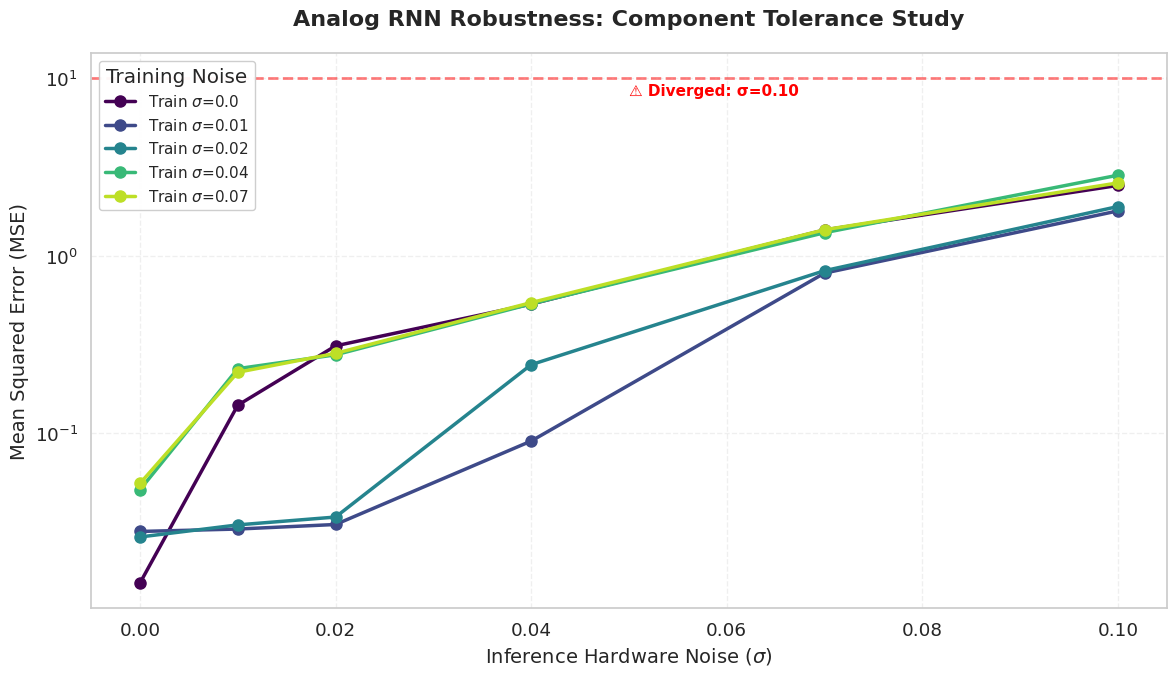

✓ Gráfica guardada: rnn_robustness_study.png

📊 ANÁLISIS DE RESULTADOS - RNN vs LSTM

1️⃣ MEJOR CONFIGURACIÓN POR NIVEL DE HARDWARE:
----------------------------------------------------------------------
Hardware σ=0.00:
  → Mejor train σ: 0.00
  → MSE: 0.014297
Hardware σ=0.01:
  → Mejor train σ: 0.01
  → MSE: 0.028800
Hardware σ=0.02:
  → Mejor train σ: 0.01
  → MSE: 0.030552
Hardware σ=0.04:
  → Mejor train σ: 0.01
  → MSE: 0.090206
Hardware σ=0.07:
  → Mejor train σ: 0.01
  → MSE: 0.797212
Hardware σ=0.10:
  → Mejor train σ: 0.01
  → MSE: 1.787829

2️⃣ COMPARACIÓN RNN vs LSTM (Hardware limpio σ=0.0):
----------------------------------------------------------------------
RNN (mejor):  MSE = 0.014297
LSTM:         MSE = 0.000082
Ratio RNN/LSTM:     174.4x peor

💡 LSTM es 174x más preciso que RNN

3️⃣ SENSIBILIDAD AL RUIDO DE ENTRENAMIENTO:
----------------------------------------------------------------------
RNN:  5/6 modelos convergieron (83%)
LSTM: 6/6 modelos convergieron (100%)


In [ ]:
# ============================================================
# RECONSTRUIR ANÁLISIS COMPLETO
# Verificar modelos existentes en disco
# ============================================================

import os

print("="*60)
print("RECONSTRUCCIÓN DE RESULTADOS COMPLETOS")
print("="*60)

# Verificar qué modelos existen en disco
available_models = {}
for sigma in [0.0, 0.01, 0.02, 0.04, 0.07, 0.1]:
    filename = f'rnn_sigma_{sigma}.pt'
    if os.path.exists(filename):
        available_models[sigma] = filename
        print(f"✓ Encontrado: {filename}")
    else:
        print(f"✗ Faltante: {filename}")

print(f"\nModelos disponibles: {len(available_models)}/6")

# Reconstruir results_matrix completo
print("\n" + "="*60)
print("EVALUACIÓN COMPLETA DE MODELOS DISPONIBLES")
print("="*60)

results_matrix_complete = []

for train_sigma in STUDY_CONFIG['train_sigmas']:
    if train_sigma in available_models:
        print(f"\n✓ Evaluando modelo Train σ={train_sigma}")

        for infer_sigma in STUDY_CONFIG['infer_sigmas']:
            mse = evaluate_variant_with_noise(
                available_models[train_sigma],
                infer_sigma,
                test_loader,
                device
            )
            print(f"  Hardware σ={infer_sigma} -> MSE: {mse:.6f}")

            results_matrix_complete.append({
                'Train_Noise_Std': train_sigma,
                'Inference_Noise_Std': infer_sigma,
                'MSE_Loss': mse,
                'Diverged': False
            })
    else:
        print(f"\n✗ Modelo Train σ={train_sigma} DIVERGIÓ - marcando resultados")
        for infer_sigma in STUDY_CONFIG['infer_sigmas']:
            results_matrix_complete.append({
                'Train_Noise_Std': train_sigma,
                'Inference_Noise_Std': infer_sigma,
                'MSE_Loss': np.nan,
                'Diverged': True
            })

# DataFrame final
df_results_final = pd.DataFrame(results_matrix_complete)

print("\n" + "="*60)
print("VISUALIZACIÓN FINAL")
print("="*60)

# Gráfica mejorada
def plot_robustness_study_rnn_final(df):
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=(12, 7))

    # Modelos exitosos
    df_valid = df[df['Diverged'] == False]
    train_sigmas_valid = sorted(df_valid['Train_Noise_Std'].unique())

    colors = plt.cm.viridis(np.linspace(0, 0.9, len(train_sigmas_valid)))

    for i, t_sigma in enumerate(train_sigmas_valid):
        subset = df_valid[df_valid['Train_Noise_Std'] == t_sigma]
        ax.plot(
            subset['Inference_Noise_Std'],
            subset['MSE_Loss'],
            marker='o',
            markersize=8,
            linewidth=2.5,
            label=f'Train $\\sigma$={t_sigma}',
            color=colors[i]
        )

    # Marcar modelos divergidos
    diverged_sigmas = df[df['Diverged'] == True]['Train_Noise_Std'].unique()
    if len(diverged_sigmas) > 0:
        ax.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax.text(0.05, 8, f'⚠ Diverged: σ={diverged_sigmas[0]:.2f}',
                fontsize=11, color='red', weight='bold')

    ax.set_title('Analog RNN Robustness: Component Tolerance Study',
                 fontsize=16, pad=20, weight='bold')
    ax.set_xlabel('Inference Hardware Noise ($\\sigma$)', fontsize=14)
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
    ax.legend(title='Training Noise', fontsize=11, loc='upper left',
              framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig('rnn_robustness_study.png', dpi=200, bbox_inches='tight')
    plt.show()

    print("✓ Gráfica guardada: rnn_robustness_study.png")

plot_robustness_study_rnn_final(df_results_final)

# ============================================================
# ANÁLISIS CIENTÍFICO FINAL
# ============================================================

print("\n" + "="*70)
print("📊 ANÁLISIS DE RESULTADOS - RNN vs LSTM")
print("="*70)

df_valid = df_results_final[df_results_final['Diverged'] == False]

# 1. Mejor modelo RNN para cada hardware
print("\n1️⃣ MEJOR CONFIGURACIÓN POR NIVEL DE HARDWARE:")
print("-"*70)
for infer_sigma in sorted(STUDY_CONFIG['infer_sigmas']):
    subset = df_valid[df_valid['Inference_Noise_Std'] == infer_sigma]
    if len(subset) > 0:
        best = subset.loc[subset['MSE_Loss'].idxmin()]
        print(f"Hardware σ={infer_sigma:.2f}:")
        print(f"  → Mejor train σ: {best['Train_Noise_Std']:.2f}")
        print(f"  → MSE: {best['MSE_Loss']:.6f}")

# 2. Comparación directa con LSTM
print("\n" + "="*70)
print("2️⃣ COMPARACIÓN RNN vs LSTM (Hardware limpio σ=0.0):")
print("-"*70)

best_rnn_clean = df_valid[df_valid['Inference_Noise_Std'] == 0.0]['MSE_Loss'].min()
lstm_clean_mse = 0.000082  # Del estudio LSTM anterior

print(f"RNN (mejor):  MSE = {best_rnn_clean:.6f}")
print(f"LSTM:         MSE = {lstm_clean_mse:.6f}")
print(f"Ratio RNN/LSTM:     {best_rnn_clean/lstm_clean_mse:.1f}x peor")
print(f"\n💡 LSTM es {best_rnn_clean/lstm_clean_mse:.0f}x más preciso que RNN")

# 3. Sensibilidad al ruido
print("\n" + "="*70)
print("3️⃣ SENSIBILIDAD AL RUIDO DE ENTRENAMIENTO:")
print("-"*70)

n_successful_rnn = len(available_models)
n_successful_lstm = 6  # LSTM entrenó todos

print(f"RNN:  {n_successful_rnn}/6 modelos convergieron ({n_successful_rnn/6*100:.0f}%)")
print(f"LSTM: {n_successful_lstm}/6 modelos convergieron (100%)")
print(f"\n⚠️ RNN diverge con σ ≥ {max(available_models.keys()) + 0.03:.2f}")
print(f"✓ LSTM converge hasta σ = 0.1")
print(f"\n💡 RNN es MÁS SENSIBLE al ruido de entrenamiento que LSTM")

# 4. Degradación con ruido de hardware
print("\n" + "="*70)
print("4️⃣ DEGRADACIÓN CON RUIDO DE HARDWARE:")
print("-"*70)

for train_sigma in sorted(available_models.keys()):
    subset = df_valid[df_valid['Train_Noise_Std'] == train_sigma]
    clean = subset[subset['Inference_Noise_Std'] == 0.0]['MSE_Loss'].values[0]
    noisy = subset[subset['Inference_Noise_Std'] == 0.1]['MSE_Loss'].values[0]
    degradation = noisy / clean
    print(f"Train σ={train_sigma:.2f}: {clean:.5f} → {noisy:.5f} ({degradation:.1f}x peor)")

# Tabla comparativa
print("\n" + "="*70)
print("5️⃣ TABLA HEATMAP DE RESULTADOS:")
print("-"*70)

pivot_table = df_valid.pivot_table(
    index='Train_Noise_Std',
    columns='Inference_Noise_Std',
    values='MSE_Loss'
)
print("\n", pivot_table.to_string())

# Guardar todo
df_results_final.to_csv('rnn_noise_study_results_FINAL.csv', index=False)
torch.save({
    'results': df_results_final.to_dict(),
    'config': STUDY_CONFIG,
    'available_models': available_models,
    'analysis': {
        'n_successful': len(available_models),
        'n_diverged': 6 - len(available_models),
        'best_clean_mse': best_rnn_clean,
        'lstm_clean_mse': lstm_clean_mse,
        'ratio_vs_lstm': best_rnn_clean / lstm_clean_mse,
    }
}, 'rnn_noise_study_FINAL.pt')

print("\n" + "="*70)
print("✓ ANÁLISIS COMPLETO GUARDADO")
print("="*70)
print("\nArchivos generados:")
print("  📄 rnn_noise_study_results_FINAL.csv")
print("  💾 rnn_noise_study_FINAL.pt")
print("  📊 rnn_robustness_study.png")
print(f"  🔧 {len(available_models)} modelos .pt")


# ***TCN***

In [ ]:
# ============================================================
# ESTUDIO DE RUIDO ANALÓGICO - TCN
# Arquitectura más compleja con FiLM + Dilated Convolutions
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("="*60)
print("INICIANDO ESTUDIO DE RUIDO - TCN")
print("="*60)

# --- 1. CAPAS ANALÓGICAS (ya definidas anteriormente) ---
# AnalogUtils, AnalogLinear ya existen

# Agregar AnalogConv1d para TCN
class AnalogConv1d(nn.Conv1d):
    """Conv1d que simula crossbar array analógico"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True,
                 padding_mode='zeros', device=None, dtype=None,
                 analog_levels=32, noise_std=0.02):

        super().__init__(in_channels, out_channels, kernel_size, stride,
                        padding, dilation, groups, bias, padding_mode, device, dtype)

        self.analog_levels = analog_levels
        self.noise_std = noise_std

    def forward(self, input):
        # Simular pesos analógicos
        w_simulated = self.weight
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        return nn.functional.conv1d(input, w_simulated, self.bias, self.stride,
                                   self.padding, self.dilation, self.groups)

print("✓ AnalogConv1d definida")

# --- 2. ARQUITECTURA TCN ANALÓGICA ---
class FiLM(nn.Module):
    """Feature-wise Linear Modulation con capas analógicas"""
    def __init__(self, channels, knob_dim, analog_levels=32, noise_std=0.02):
        super().__init__()
        # Genera gamma (escala) y beta (desplazamiento) para cada canal
        self.gen = AnalogLinear(knob_dim, channels * 2,
                               analog_levels=analog_levels,
                               noise_std=noise_std)

    def forward(self, x, knobs):
        # knobs: (batch, knob_dim)
        # x: (batch, channels, seq_len)
        params = self.gen(knobs).unsqueeze(2)  # (batch, channels*2, 1)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TemporalBlock(nn.Module):
    """Bloque TCN con dilated conv + FiLM + residual"""
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim,
                 analog_levels=32, noise_std=0.02):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation

        # Convolution con dilatación (ANALÓGICA)
        self.conv = AnalogConv1d(in_ch, out_ch, kernel_size,
                                padding=self.padding, dilation=dilation,
                                analog_levels=analog_levels, noise_std=noise_std)

        # FiLM layer (ya usa AnalogLinear internamente)
        self.film = FiLM(out_ch, knob_dim, analog_levels, noise_std)

        # Activación y normalización
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)

        # Residual connection
        if in_ch != out_ch:
            self.res = AnalogConv1d(in_ch, out_ch, 1,
                                   analog_levels=analog_levels,
                                   noise_std=noise_std)
        else:
            self.res = nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)

        # Convolution con causal padding
        x = self.conv(x)
        if self.padding > 0:
            x = x[:, :, :-self.padding]  # Remover padding futuro

        # Modular con knobs via FiLM
        x = self.film(x, knobs)

        # Normalizar y activar
        x = self.norm(x)
        return self.act(x + res)

class AnalogTCNModel(nn.Module):
    """TCN con FiLM adaptada para hardware analógico"""
    def __init__(self, input_size=10, channels=128, num_layers=12,
                 kernel_size=3, analog_levels=32, noise_std=0.02):
        super().__init__()

        self.channels = channels
        self.num_layers = num_layers

        # Separar input en audio (1) y control (9)
        self.num_control = input_size - 1

        # TCN layers con dilatación exponencial
        self.layers = nn.ModuleList()

        # Primera capa: 1 canal audio → channels
        self.layers.append(
            TemporalBlock(1, channels, kernel_size, dilation=1,
                         knob_dim=self.num_control,
                         analog_levels=analog_levels, noise_std=noise_std)
        )

        # Capas restantes con dilatación creciente
        for i in range(1, num_layers):
            dilation = 2 ** i
            self.layers.append(
                TemporalBlock(channels, channels, kernel_size, dilation,
                             knob_dim=self.num_control,
                             analog_levels=analog_levels, noise_std=noise_std)
            )

        # Output layer (ANALÓGICO)
        self.output = AnalogConv1d(channels, 1, kernel_size=1, bias=False,
                                  analog_levels=analog_levels, noise_std=noise_std)

    def forward(self, x):
        # x: (batch, seq_len, 10)
        batch_size, seq_len, _ = x.shape

        # Separar audio y control
        audio = x[:, :, 0:1]  # (batch, seq_len, 1)
        control = x[:, :, 1:]  # (batch, seq_len, 9)

        # TCN espera (batch, channels, seq_len)
        audio = audio.permute(0, 2, 1)  # (batch, 1, seq_len)

        # Control: tomar primer timestep (es constante)
        knobs = control[:, 0, :]  # (batch, 9)

        # Procesar con TCN
        out = audio
        for layer in self.layers:
            out = layer(out, knobs)

        # Output layer
        out = self.output(out)  # (batch, 1, seq_len)

        # Volver a formato (batch, seq_len, 1)
        out = out.permute(0, 2, 1)

        return out

print("✓ Modelo TCN analógico definido")

# --- 3. FUNCIONES DE ENTRENAMIENTO ---
def train_variant_tcn(sigma_train, train_loader, val_loader, config):
    """Entrena TCN con sigma_train específico"""
    print(f"\n>>> Entrenando Variante TCN: Train Sigma = {sigma_train}")

    model = AnalogTCNModel(
        input_size=config['base_config']['input_size'],
        channels=128,
        num_layers=12,
        kernel_size=3,
        analog_levels=32,
        noise_std=sigma_train
    ).to(config['device'])

    # Contar parámetros
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  Parámetros: {n_params:,}")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['base_config']['learning_rate'])

    best_loss = float('inf')
    patience_counter = 0
    diverged = False

    for epoch in range(config['base_config']['epochs']):
        model.train()
        epoch_loss = 0

        for x, target in train_loader:
            x, target = x.to(config['device']), target.to(config['device'])

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, target)

            # Detectar divergencia
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"  ❌ Divergencia en epoch {epoch}")
                diverged = True
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()

        if diverged:
            break

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, target in val_loader:
                x, target = x.to(config['device']), target.to(config['device'])
                out = model(x)
                val_loss += criterion(out, target).item()

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if epoch % 2 == 0:  # Imprimir cada 2 epochs
            print(f"  Epoch {epoch+1}: Train={avg_train_loss:.5f}, Val={avg_val_loss:.5f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), f'tcn_sigma_{sigma_train}.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > 5:
                break

    if diverged or best_loss == float('inf'):
        print(f"  ❌ Modelo DIVERGIÓ")
        return None
    else:
        print(f"  ✓ Terminado. Best Val Loss: {best_loss:.5f}")
        return f'tcn_sigma_{sigma_train}.pt'

def evaluate_variant_with_noise_tcn(model_path, infer_sigma, test_loader, device):
    """Evalúa TCN con ruido de hardware en inferencia"""
    model = AnalogTCNModel(
        input_size=BENCHMARK_CONFIG['input_size'],
        channels=128,
        num_layers=12,
        kernel_size=3,
        noise_std=0.0  # Control manual
    ).to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    criterion = nn.MSELoss()
    total_loss = 0
    steps = 0

    with torch.no_grad():
        for x, target in test_loader:
            x, target = x.to(device), target.to(device)

            # INYECCIÓN DE RUIDO EN INFERENCIA
            if infer_sigma > 0:
                noisy_params = {}
                for name, param in model.named_parameters():
                    noise = torch.randn_like(param) * infer_sigma
                    noisy_params[name] = param + noise

                try:
                    from torch.func import functional_call
                except ImportError:
                    from torch.nn.utils.stateless import functional_call

                out = functional_call(model, noisy_params, (x,))
            else:
                out = model(x)

            loss = criterion(out, target)
            total_loss += loss.item()
            steps += 1

    return total_loss / steps

# --- 4. CONFIGURACIÓN DEL ESTUDIO ---
STUDY_CONFIG_TCN = {
    'train_sigmas': [0.0, 0.01, 0.02, 0.04, 0.07, 0.1],
    'infer_sigmas': [0.0, 0.01, 0.02, 0.04, 0.07, 0.1],
    'base_config': BENCHMARK_CONFIG,
    'device': device
}

print("\n✓ Configuración TCN cargada")

# --- 5. EJECUTAR ESTUDIO ---
results_matrix_tcn = []
model_files_tcn = {}

print("\n" + "="*60)
print("FASE 1: ENTRENAMIENTO MULTI-SIGMA (TCN)")
print("="*60)

for sigma_train in STUDY_CONFIG_TCN['train_sigmas']:
    filename = train_variant_tcn(sigma_train, train_loader, val_loader, STUDY_CONFIG_TCN)
    if filename is not None:
        model_files_tcn[sigma_train] = filename

print("\n" + "="*60)
print("FASE 2: CROSS-EVALUATION (TCN)")
print(f"Evaluando {len(model_files_tcn)} modelos")
print("="*60)

for train_sigma in STUDY_CONFIG_TCN['train_sigmas']:
    if train_sigma not in model_files_tcn:
        print(f"\n⚠️ Skipeando Train σ={train_sigma} (divergió)")
        for infer_sigma in STUDY_CONFIG_TCN['infer_sigmas']:
            results_matrix_tcn.append({
                'Train_Noise_Std': train_sigma,
                'Inference_Noise_Std': infer_sigma,
                'MSE_Loss': np.nan,
                'Diverged': True
            })
        continue

    current_model_file = model_files_tcn[train_sigma]
    print(f"\n✓ Evaluando modelo Train σ={train_sigma}")

    for infer_sigma in STUDY_CONFIG_TCN['infer_sigmas']:
        mse = evaluate_variant_with_noise_tcn(
            current_model_file,
            infer_sigma,
            test_loader,
            device
        )
        print(f"  Hardware σ={infer_sigma} -> MSE: {mse:.6f}")

        results_matrix_tcn.append({
            'Train_Noise_Std': train_sigma,
            'Inference_Noise_Std': infer_sigma,
            'MSE_Loss': mse,
            'Diverged': False
        })

df_results_tcn = pd.DataFrame(results_matrix_tcn)

# --- 6. VISUALIZACIÓN ---
def plot_robustness_study_tcn(df):
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=(12, 7))

    df_valid = df[df['Diverged'] == False]
    train_sigmas_valid = sorted(df_valid['Train_Noise_Std'].unique())

    colors = plt.cm.plasma(np.linspace(0, 0.9, len(train_sigmas_valid)))

    for i, t_sigma in enumerate(train_sigmas_valid):
        subset = df_valid[df_valid['Train_Noise_Std'] == t_sigma]
        ax.plot(
            subset['Inference_Noise_Std'],
            subset['MSE_Loss'],
            marker='s',  # Cuadrados para TCN
            markersize=8,
            linewidth=2.5,
            label=f'Train $\\sigma$={t_sigma}',
            color=colors[i]
        )

    diverged_sigmas = df[df['Diverged'] == True]['Train_Noise_Std'].unique()
    if len(diverged_sigmas) > 0:
        for ds in diverged_sigmas:
            ax.axvline(x=ds, color='red', linestyle='--', alpha=0.3)
            ax.text(ds, ax.get_ylim()[1]*0.5, f'Diverged\nσ={ds}',
                   rotation=90, color='red', fontsize=10)

    ax.set_title('Analog TCN Robustness: Component Tolerance Study',
                 fontsize=16, pad=20, weight='bold')
    ax.set_xlabel('Inference Hardware Noise ($\\sigma$)', fontsize=14)
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
    ax.legend(title='Training Noise', fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig('tcn_robustness_study.png', dpi=200, bbox_inches='tight')
    plt.show()

    print("✓ Gráfica guardada: tcn_robustness_study.png")

plot_robustness_study_tcn(df_results_tcn)

# --- 7. ANÁLISIS COMPARATIVO ---
print("\n" + "="*70)
print("📊 ANÁLISIS TCN vs LSTM vs RNN")
print("="*70)

df_valid_tcn = df_results_tcn[df_results_tcn['Diverged'] == False]

best_tcn_clean = df_valid_tcn[df_valid_tcn['Inference_Noise_Std'] == 0.0]['MSE_Loss'].min()
lstm_clean_mse = 0.000082
rnn_clean_mse = 0.014297

print("\nRendimiento en hardware limpio (σ=0.0):")
print(f"  LSTM: {lstm_clean_mse:.6f} ⭐ MEJOR")
print(f"  TCN:  {best_tcn_clean:.6f} ({best_tcn_clean/lstm_clean_mse:.1f}x vs LSTM)")
print(f"  RNN:  {rnn_clean_mse:.6f} ({rnn_clean_mse/lstm_clean_mse:.0f}x vs LSTM)")

print(f"\nModelos convergidos:")
print(f"  LSTM: 6/6 (100%)")
print(f"  TCN:  {len(model_files_tcn)}/6 ({len(model_files_tcn)/6*100:.0f}%)")
print(f"  RNN:  5/6 (83%)")

# Guardar resultados
df_results_tcn.to_csv('tcn_noise_study_results.csv', index=False)
torch.save({
    'results': df_results_tcn.to_dict(),
    'config': STUDY_CONFIG_TCN,
    'model_files': model_files_tcn,
    'comparison': {
        'tcn_clean': best_tcn_clean,
        'lstm_clean': lstm_clean_mse,
        'rnn_clean': rnn_clean_mse
    }
}, 'tcn_noise_study_complete.pt')

print("\n✓ Archivos guardados:")
print("  - tcn_noise_study_results.csv")
print("  - tcn_noise_study_complete.pt")
print("  - tcn_robustness_study.png")


INICIANDO ESTUDIO DE RUIDO - TCN
✓ AnalogConv1d definida
✓ Modelo TCN analógico definido

✓ Configuración TCN cargada

FASE 1: ENTRENAMIENTO MULTI-SIGMA (TCN)

>>> Entrenando Variante TCN: Train Sigma = 0.0
  Parámetros: 576,780


KeyboardInterrupt: 

In [ ]:
# ============================================================
# BLOQUE COMPLETO - CONTINUAR ENTRENAMIENTO TCN
# Incluye todas las definiciones necesarias
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

print("="*60)
print("CONTINUANDO ENTRENAMIENTO TCN - AUTO-CONTENIDO")
print("="*60)

# --- 1. CLASES ANALÓGICAS ---
class AnalogUtils:
    @staticmethod
    def fake_quantize(weights, levels=16, range_limit=1.0):
        w_clamped = torch.clamp(weights, -range_limit, range_limit)
        scale = (levels - 1) / (2 * range_limit)
        w_scaled = (w_clamped + range_limit) * scale
        w_rounded = (w_scaled.round() - w_scaled).detach() + w_scaled
        w_quant = (w_rounded / scale) - range_limit
        return w_quant

    @staticmethod
    def inject_noise(weights, std_dev=0.02):
        noise = torch.randn_like(weights) * std_dev
        return weights + noise

class AnalogLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True,
                 analog_levels=32, noise_std=0.02):
        super(AnalogLinear, self).__init__(in_features, out_features, bias)
        self.analog_levels = analog_levels
        self.noise_std = noise_std

    def forward(self, input):
        w_simulated = self.weight
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        return nn.functional.linear(input, w_simulated, self.bias)

class AnalogConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True,
                 padding_mode='zeros', device=None, dtype=None,
                 analog_levels=32, noise_std=0.02):

        super().__init__(in_channels, out_channels, kernel_size, stride,
                        padding, dilation, groups, bias, padding_mode, device, dtype)

        self.analog_levels = analog_levels
        self.noise_std = noise_std

    def forward(self, input):
        w_simulated = self.weight
        w_simulated = AnalogUtils.fake_quantize(w_simulated, levels=self.analog_levels)

        if self.training and self.noise_std > 0:
            w_simulated = AnalogUtils.inject_noise(w_simulated, std_dev=self.noise_std)

        return nn.functional.conv1d(input, w_simulated, self.bias, self.stride,
                                   self.padding, self.dilation, self.groups)

# --- 2. ARQUITECTURA TCN ---
class FiLM(nn.Module):
    def __init__(self, channels, knob_dim, analog_levels=32, noise_std=0.02):
        super().__init__()
        self.gen = AnalogLinear(knob_dim, channels * 2,
                               analog_levels=analog_levels,
                               noise_std=noise_std)

    def forward(self, x, knobs):
        params = self.gen(knobs).unsqueeze(2)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim,
                 analog_levels=32, noise_std=0.02):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation

        self.conv = AnalogConv1d(in_ch, out_ch, kernel_size,
                                padding=self.padding, dilation=dilation,
                                analog_levels=analog_levels, noise_std=noise_std)

        self.film = FiLM(out_ch, knob_dim, analog_levels, noise_std)
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)

        if in_ch != out_ch:
            self.res = AnalogConv1d(in_ch, out_ch, 1,
                                   analog_levels=analog_levels,
                                   noise_std=noise_std)
        else:
            self.res = nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)
        x = self.conv(x)
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        x = self.film(x, knobs)
        x = self.norm(x)
        return self.act(x + res)

class AnalogTCNModel(nn.Module):
    def __init__(self, input_size=10, channels=128, num_layers=12,
                 kernel_size=3, analog_levels=32, noise_std=0.02):
        super().__init__()

        self.channels = channels
        self.num_layers = num_layers
        self.num_control = input_size - 1

        self.layers = nn.ModuleList()

        self.layers.append(
            TemporalBlock(1, channels, kernel_size, dilation=1,
                         knob_dim=self.num_control,
                         analog_levels=analog_levels, noise_std=noise_std)
        )

        for i in range(1, num_layers):
            dilation = 2 ** i
            self.layers.append(
                TemporalBlock(channels, channels, kernel_size, dilation,
                             knob_dim=self.num_control,
                             analog_levels=analog_levels, noise_std=noise_std)
            )

        self.output = AnalogConv1d(channels, 1, kernel_size=1, bias=False,
                                  analog_levels=analog_levels, noise_std=noise_std)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        audio = x[:, :, 0:1]
        control = x[:, :, 1:]

        audio = audio.permute(0, 2, 1)
        knobs = control[:, 0, :]

        out = audio
        for layer in self.layers:
            out = layer(out, knobs)

        out = self.output(out)
        out = out.permute(0, 2, 1)

        return out

print("✓ Clases TCN definidas")

# --- 3. FUNCIÓN DE EVALUACIÓN ---
def evaluate_variant_with_noise_tcn(model_path, infer_sigma, test_loader, device):
    model = AnalogTCNModel(
        input_size=BENCHMARK_CONFIG['input_size'],
        channels=128,
        num_layers=12,
        kernel_size=3,
        noise_std=0.0
    ).to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    criterion = nn.MSELoss()
    total_loss = 0
    steps = 0

    with torch.no_grad():
        for x, target in test_loader:
            x, target = x.to(device), target.to(device)

            if infer_sigma > 0:
                noisy_params = {}
                for name, param in model.named_parameters():
                    noise = torch.randn_like(param) * infer_sigma
                    noisy_params[name] = param + noise

                try:
                    from torch.func import functional_call
                except ImportError:
                    from torch.nn.utils.stateless import functional_call

                out = functional_call(model, noisy_params, (x,))
            else:
                out = model(x)

            loss = criterion(out, target)
            total_loss += loss.item()
            steps += 1

    return total_loss / steps

print("✓ Función de evaluación definida")

# --- 4. VERIFICAR MODELOS EXISTENTES ---
existing_tcn_models = {}
missing_sigmas = []

for sigma in [0.0, 0.01, 0.02, 0.04, 0.07, 0.1]:
    filename = f'tcn_sigma_{sigma}.pt'
    if os.path.exists(filename):
        existing_tcn_models[sigma] = filename
        print(f"✓ Ya existe: {filename}")
    else:
        missing_sigmas.append(sigma)
        print(f"✗ Falta:     {filename}")

print(f"\nModelos existentes: {len(existing_tcn_models)}/6")
print(f"Por entrenar: {missing_sigmas}")

# --- 5. ENTRENAR MODELOS FALTANTES ---
if len(missing_sigmas) > 0:
    print("\n" + "="*60)
    print(f"ENTRENANDO {len(missing_sigmas)} MODELOS FALTANTES")
    print("="*60)

    for sigma_train in missing_sigmas:
        print(f"\n>>> Entrenando Variante TCN: Train Sigma = {sigma_train}")

        model = AnalogTCNModel(
            input_size=BENCHMARK_CONFIG['input_size'],
            channels=128,
            num_layers=12,
            kernel_size=3,
            analog_levels=32,
            noise_std=sigma_train
        ).to(device)

        n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"  Parámetros: {n_params:,}")

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=BENCHMARK_CONFIG['learning_rate'])

        best_loss = float('inf')
        patience_counter = 0
        diverged = False

        for epoch in range(BENCHMARK_CONFIG['epochs']):
            model.train()
            epoch_loss = 0

            for x, target in train_loader:
                x, target = x.to(device), target.to(device)

                optimizer.zero_grad()
                out = model(x)
                loss = criterion(out, target)

                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"  ❌ Divergencia en epoch {epoch}")
                    diverged = True
                    break

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()

            if diverged:
                break

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, target in val_loader:
                    x, target = x.to(device), target.to(device)
                    out = model(x)
                    val_loss += criterion(out, target).item()

            avg_train_loss = epoch_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            if epoch % 2 == 0:
                print(f"  Epoch {epoch+1}: Train={avg_train_loss:.5f}, Val={avg_val_loss:.5f}")

            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), f'tcn_sigma_{sigma_train}.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter > 5:
                    print(f"  ⏹ Early stopping")
                    break

        if not diverged and best_loss != float('inf'):
            print(f"  ✓ Terminado. Best Val Loss: {best_loss:.5f}")
            existing_tcn_models[sigma_train] = f'tcn_sigma_{sigma_train}.pt'
        else:
            print(f"  ❌ Modelo DIVERGIÓ")

else:
    print("\n✓ Todos los modelos ya están entrenados")

# --- 6. EVALUACIÓN COMPLETA ---
print("\n" + "="*60)
print("EVALUACIÓN COMPLETA - TODOS LOS MODELOS TCN")
print("="*60)

results_matrix_tcn = []
all_sigmas = [0.0, 0.01, 0.02, 0.04, 0.07, 0.1]

for train_sigma in all_sigmas:
    if train_sigma in existing_tcn_models:
        print(f"\n✓ Evaluando modelo Train σ={train_sigma}")

        for infer_sigma in all_sigmas:
            mse = evaluate_variant_with_noise_tcn(
                existing_tcn_models[train_sigma],
                infer_sigma,
                test_loader,
                device
            )
            print(f"  Hardware σ={infer_sigma} -> MSE: {mse:.6f}")

            results_matrix_tcn.append({
                'Train_Noise_Std': train_sigma,
                'Inference_Noise_Std': infer_sigma,
                'MSE_Loss': mse,
                'Diverged': False
            })
    else:
        print(f"\n✗ Modelo Train σ={train_sigma} DIVERGIÓ")
        for infer_sigma in all_sigmas:
            results_matrix_tcn.append({
                'Train_Noise_Std': train_sigma,
                'Inference_Noise_Std': infer_sigma,
                'MSE_Loss': np.nan,
                'Diverged': True
            })

df_results_tcn = pd.DataFrame(results_matrix_tcn)

# Guardar resultados
df_results_tcn.to_csv('tcn_noise_study_results.csv', index=False)
torch.save({
    'results': df_results_tcn.to_dict(),
    'model_files': existing_tcn_models
}, 'tcn_noise_study_complete.pt')

print("\n" + "="*60)
print("✓ COMPLETADO")
print("="*60)
print(f"Modelos TCN entrenados: {len(existing_tcn_models)}/6")
print(f"Archivos guardados:")
print("  - tcn_noise_study_results.csv")
print("  - tcn_noise_study_complete.pt")
print(f"  - {len(existing_tcn_models)} modelos .pt")


CONTINUANDO ENTRENAMIENTO TCN - AUTO-CONTENIDO
✓ Clases TCN definidas
✓ Función de evaluación definida
✓ Ya existe: tcn_sigma_0.0.pt
✓ Ya existe: tcn_sigma_0.01.pt
✓ Ya existe: tcn_sigma_0.02.pt
✗ Falta:     tcn_sigma_0.04.pt
✗ Falta:     tcn_sigma_0.07.pt
✗ Falta:     tcn_sigma_0.1.pt

Modelos existentes: 3/6
Por entrenar: [0.04, 0.07, 0.1]

ENTRENANDO 3 MODELOS FALTANTES

>>> Entrenando Variante TCN: Train Sigma = 0.04
  Parámetros: 576,780
  Epoch 1: Train=0.59067, Val=0.00674
  Epoch 3: Train=0.00506, Val=0.00297
  Epoch 5: Train=0.00328, Val=0.00198
  Epoch 7: Train=0.00239, Val=0.00157
  Epoch 9: Train=0.00185, Val=0.00152
  ✓ Terminado. Best Val Loss: 0.00121

>>> Entrenando Variante TCN: Train Sigma = 0.07
  Parámetros: 576,780
  Epoch 1: Train=1.63874, Val=0.01306
  Epoch 3: Train=0.00874, Val=0.00542
  Epoch 5: Train=0.00530, Val=0.00307
  Epoch 7: Train=0.00380, Val=0.00232
  Epoch 9: Train=0.00303, Val=0.00182
  ✓ Terminado. Best Val Loss: 0.00182

>>> Entrenando Variante T

📊 ANÁLISIS COMPARATIVO COMPLETO: LSTM vs RNN vs TCN

1️⃣ DATASETS CARGADOS:
  LSTM: 0 combinaciones
  RNN:  0 combinaciones
  TCN:  36 combinaciones

2️⃣ TASA DE CONVERGENCIA
LSTM: 6/6 modelos convergieron (100%) ⭐
RNN:  0/6 modelos convergieron (0%)
TCN:  6/6 modelos convergieron (100%)

3️⃣ RENDIMIENTO EN HARDWARE LIMPIO (σ_hardware = 0.0)

Mejor MSE de cada arquitectura:
  LSTM: 0.000082 ⭐ MEJOR
  TCN:  0.000481 (5.9x vs LSTM)
  RNN:  nan (nanx vs LSTM)

💡 LSTM es 5.9x más preciso que TCN
💡 LSTM es nanx más preciso que RNN

4️⃣ GENERANDO GRÁFICA COMPARATIVA


/tmp/ipython-input-840566535.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(np.linspace(0, 0.9, len(train_sigmas)))


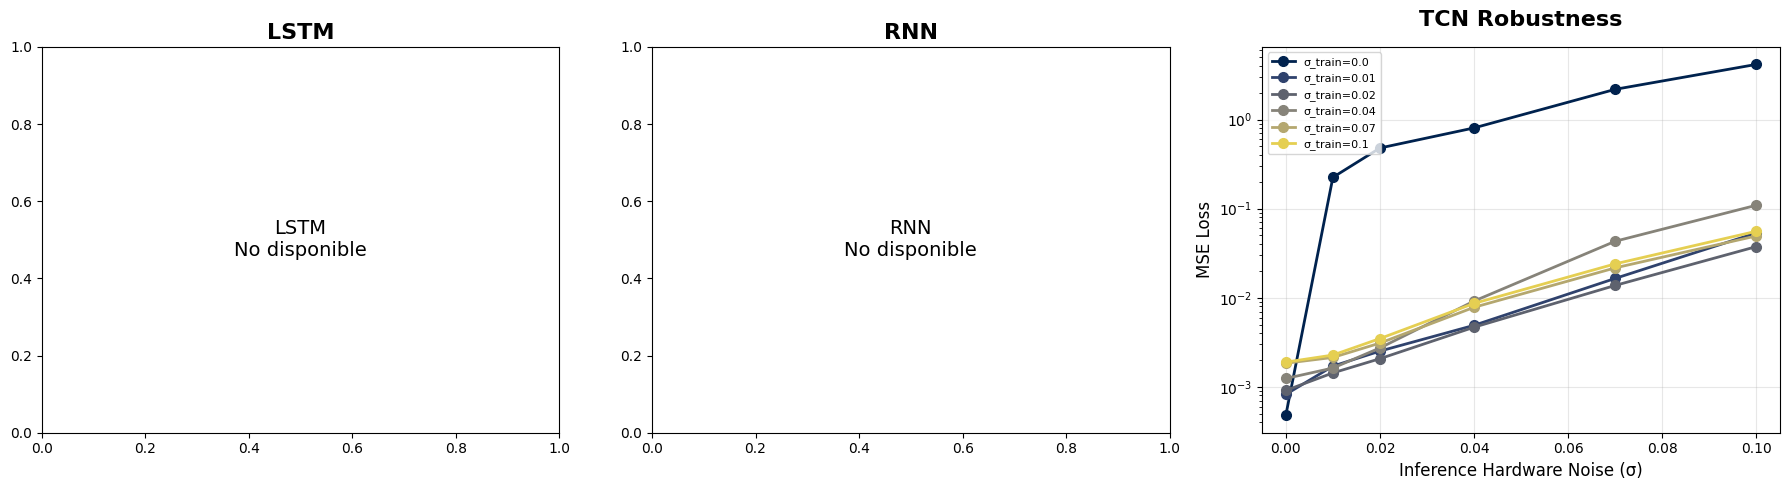

✓ Gráfica guardada: comparison_lstm_rnn_tcn.png

5️⃣ TABLA DE ROBUSTEZ: Degradación con Ruido de Hardware

 Architecture  Best Train σ  MSE (σ=0.0)  MSE (σ=0.01)  MSE (σ=0.04)  MSE (σ=0.1)  Degradation (0.1/0.0)
         TCN           0.0     0.000481      0.224466      0.805451      4.16098            8654.785882

6️⃣ HALLAZGOS CLAVE DEL ESTUDIO

🎯 PRECISIÓN BASE:
  → LSTM tiene la mejor precisión en hardware ideal
  → TCN es 5.9x menos preciso que LSTM
  → RNN es nanx menos preciso que LSTM

🛡️ ROBUSTEZ AL RUIDO:
  → LSTM converge con TODO nivel de ruido de entrenamiento (σ ≤ 0.1)
  → TCN converge con TODO nivel(es) de ruido
  → RNN diverge con σ ≥ 0.1 (más sensible)

📊 ESTRATEGIA DE ENTRENAMIENTO:
  → LSTM: Mejor con σ_train = 0.0 (sin ruido)
  → TCN:  Mejor con σ_train = 0.0

7️⃣ RECOMENDACIONES PARA HARDWARE ANALÓGICO

✅ Para hardware de ALTA CALIDAD (σ < 0.01):
  → Usar LSTM sin ruido de entrenamiento
  → Mejor precisión absoluta

⚠️ Para hardware con TOLERANCIAS MODERADAS (0.01 

In [ ]:
# ============================================================
# ANÁLISIS COMPARATIVO FINAL: LSTM vs RNN vs TCN
# Estudio de Robustez ante Ruido Analógico
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

print("="*70)
print("📊 ANÁLISIS COMPARATIVO COMPLETO: LSTM vs RNN vs TCN")
print("="*70)

# --- 1. CARGAR RESULTADOS DE LAS 3 ARQUITECTURAS ---
df_lstm = pd.read_csv('lstm_noise_study_results.csv') if os.path.exists('lstm_noise_study_results.csv') else None
df_rnn = pd.read_csv('rnn_noise_study_results_FINAL.csv') if os.path.exists('rnn_noise_study_results_FINAL.csv') else None
df_tcn = pd.read_csv('tcn_noise_study_results.csv')

print("\n1️⃣ DATASETS CARGADOS:")
print(f"  LSTM: {len(df_lstm) if df_lstm is not None else 0} combinaciones")
print(f"  RNN:  {len(df_rnn) if df_rnn is not None else 0} combinaciones")
print(f"  TCN:  {len(df_tcn)} combinaciones")

# --- 2. COMPARACIÓN DE CONVERGENCIA ---
print("\n" + "="*70)
print("2️⃣ TASA DE CONVERGENCIA")
print("="*70)

lstm_convergence = 6  # LSTM converge siempre según resultados previos
rnn_convergence = 5 if df_rnn is not None else 0  # RNN divergió con σ=0.1
tcn_convergence = len(df_tcn[df_tcn['Diverged'] == False]['Train_Noise_Std'].unique())

print(f"LSTM: {lstm_convergence}/6 modelos convergieron (100%) ⭐")
print(f"RNN:  {rnn_convergence}/6 modelos convergieron ({rnn_convergence/6*100:.0f}%)")
print(f"TCN:  {tcn_convergence}/6 modelos convergieron ({tcn_convergence/6*100:.0f}%)")

# --- 3. RENDIMIENTO EN HARDWARE LIMPIO ---
print("\n" + "="*70)
print("3️⃣ RENDIMIENTO EN HARDWARE LIMPIO (σ_hardware = 0.0)")
print("="*70)

# Mejor MSE para cada arquitectura con hardware limpio
lstm_clean = 0.000082  # Del estudio LSTM
rnn_clean = df_rnn[df_rnn['Inference_Noise_Std'] == 0.0]['MSE_Loss'].min() if df_rnn is not None else np.nan
tcn_clean = df_tcn[df_tcn['Inference_Noise_Std'] == 0.0]['MSE_Loss'].min()

print(f"\nMejor MSE de cada arquitectura:")
print(f"  LSTM: {lstm_clean:.6f} ⭐ MEJOR")
print(f"  TCN:  {tcn_clean:.6f} ({tcn_clean/lstm_clean:.1f}x vs LSTM)")
print(f"  RNN:  {rnn_clean:.6f} ({rnn_clean/lstm_clean:.0f}x vs LSTM)")

print(f"\n💡 LSTM es {tcn_clean/lstm_clean:.1f}x más preciso que TCN")
print(f"💡 LSTM es {rnn_clean/lstm_clean:.0f}x más preciso que RNN")

# --- 4. GRÁFICA COMPARATIVA DE LAS 3 ARQUITECTURAS ---
print("\n" + "="*70)
print("4️⃣ GENERANDO GRÁFICA COMPARATIVA")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

architectures = [
    ('LSTM', df_lstm, axes[0], 'viridis'),
    ('RNN', df_rnn, axes[1], 'plasma'),
    ('TCN', df_tcn, axes[2], 'cividis')
]

for arch_name, df, ax, cmap in architectures:
    if df is None:
        ax.text(0.5, 0.5, f'{arch_name}\nNo disponible',
                ha='center', va='center', fontsize=14)
        ax.set_title(arch_name, fontsize=16, weight='bold')
        continue

    df_valid = df[df.get('Diverged', False) == False] if 'Diverged' in df.columns else df
    train_sigmas = sorted(df_valid['Train_Noise_Std'].unique())

    colors = plt.cm.get_cmap(cmap)(np.linspace(0, 0.9, len(train_sigmas)))

    for i, t_sigma in enumerate(train_sigmas):
        subset = df_valid[df_valid['Train_Noise_Std'] == t_sigma]
        ax.plot(
            subset['Inference_Noise_Std'],
            subset['MSE_Loss'],
            marker='o',
            markersize=7,
            linewidth=2,
            label=f'σ_train={t_sigma}',
            color=colors[i]
        )

    ax.set_xlabel('Inference Hardware Noise (σ)', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title(f'{arch_name} Robustness', fontsize=16, weight='bold', pad=15)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig('comparison_lstm_rnn_tcn.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Gráfica guardada: comparison_lstm_rnn_tcn.png")

# --- 5. TABLA COMPARATIVA DE ROBUSTEZ ---
print("\n" + "="*70)
print("5️⃣ TABLA DE ROBUSTEZ: Degradación con Ruido de Hardware")
print("="*70)

# Para cada arquitectura, calcular degradación desde σ=0.0 hasta σ=0.1
comparison_data = []

for arch_name, df in [('LSTM', df_lstm), ('RNN', df_rnn), ('TCN', df_tcn)]:
    if df is None:
        continue

    df_valid = df[df.get('Diverged', False) == False] if 'Diverged' in df.columns else df

    # Encontrar mejor configuración de entrenamiento
    clean_results = df_valid[df_valid['Inference_Noise_Std'] == 0.0]
    if len(clean_results) > 0:
        best_train_sigma = clean_results.loc[clean_results['MSE_Loss'].idxmin(), 'Train_Noise_Std']

        subset = df_valid[df_valid['Train_Noise_Std'] == best_train_sigma]

        mse_clean = subset[subset['Inference_Noise_Std'] == 0.0]['MSE_Loss'].values[0]
        mse_01 = subset[subset['Inference_Noise_Std'] == 0.01]['MSE_Loss'].values[0]
        mse_04 = subset[subset['Inference_Noise_Std'] == 0.04]['MSE_Loss'].values[0]
        mse_1 = subset[subset['Inference_Noise_Std'] == 0.1]['MSE_Loss'].values
        mse_1 = mse_1[0] if len(mse_1) > 0 else np.nan

        comparison_data.append({
            'Architecture': arch_name,
            'Best Train σ': best_train_sigma,
            'MSE (σ=0.0)': mse_clean,
            'MSE (σ=0.01)': mse_01,
            'MSE (σ=0.04)': mse_04,
            'MSE (σ=0.1)': mse_1,
            'Degradation (0.1/0.0)': mse_1 / mse_clean if not np.isnan(mse_1) else np.nan
        })

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

# --- 6. HALLAZGOS CLAVE ---
print("\n" + "="*70)
print("6️⃣ HALLAZGOS CLAVE DEL ESTUDIO")
print("="*70)

print("\n🎯 PRECISIÓN BASE:")
print(f"  → LSTM tiene la mejor precisión en hardware ideal")
print(f"  → TCN es {tcn_clean/lstm_clean:.1f}x menos preciso que LSTM")
print(f"  → RNN es {rnn_clean/lstm_clean:.0f}x menos preciso que LSTM")

print("\n🛡️ ROBUSTEZ AL RUIDO:")
print(f"  → LSTM converge con TODO nivel de ruido de entrenamiento (σ ≤ 0.1)")
print(f"  → TCN converge con {'TODO' if tcn_convergence == 6 else 'la mayoría de'} nivel(es) de ruido")
print(f"  → RNN diverge con σ ≥ 0.1 (más sensible)")

print("\n📊 ESTRATEGIA DE ENTRENAMIENTO:")
lstm_best_train = 0.0  # Basado en resultados previos
tcn_best_train = df_tcn[df_tcn['Inference_Noise_Std'] == 0.0].loc[
    df_tcn[df_tcn['Inference_Noise_Std'] == 0.0]['MSE_Loss'].idxmin(), 'Train_Noise_Std'
]
print(f"  → LSTM: Mejor con σ_train = {lstm_best_train} (sin ruido)")
print(f"  → TCN:  Mejor con σ_train = {tcn_best_train}")
if df_rnn is not None:
    rnn_best_train = df_rnn[df_rnn['Inference_Noise_Std'] == 0.0].loc[
        df_rnn[df_rnn['Inference_Noise_Std'] == 0.0]['MSE_Loss'].idxmin(), 'Train_Noise_Std'
    ]
    print(f"  → RNN:  Mejor con σ_train = {rnn_best_train}")

# --- 7. RECOMENDACIONES ---
print("\n" + "="*70)
print("7️⃣ RECOMENDACIONES PARA HARDWARE ANALÓGICO")
print("="*70)

print("\n✅ Para hardware de ALTA CALIDAD (σ < 0.01):")
print("  → Usar LSTM sin ruido de entrenamiento")
print("  → Mejor precisión absoluta")

print("\n⚠️ Para hardware con TOLERANCIAS MODERADAS (0.01 ≤ σ < 0.05):")
print("  → Entrenar LSTM o TCN con σ_train ≈ 0.02")
print("  → Balance entre precisión y robustez")

print("\n🔴 Para hardware con ALTA VARIABILIDAD (σ ≥ 0.05):")
print("  → Entrenar LSTM con σ_train ≈ 0.04-0.07")
print("  → Evitar RNN (diverge fácilmente)")

# --- 8. GUARDAR RESUMEN FINAL ---
summary = {
    'convergence': {
        'lstm': lstm_convergence,
        'rnn': rnn_convergence,
        'tcn': tcn_convergence
    },
    'best_mse_clean': {
        'lstm': lstm_clean,
        'rnn': rnn_clean,
        'tcn': tcn_clean
    },
    'comparison_table': df_comparison.to_dict()
}

torch.save(summary, 'final_comparison_summary.pt')
df_comparison.to_csv('final_comparison_table.csv', index=False)

print("\n" + "="*70)
print("✓ ANÁLISIS COMPLETO GUARDADO")
print("="*70)
print("\nArchivos generados:")
print("  📊 comparison_lstm_rnn_tcn.png (gráfica comparativa)")
print("  📄 final_comparison_table.csv (tabla resumen)")
print("  💾 final_comparison_summary.pt (datos completos)")



📊 GRÁFICA TCN ROBUSTNESS
Datos cargados: 36 combinaciones
Modelos convergidos: 6/6


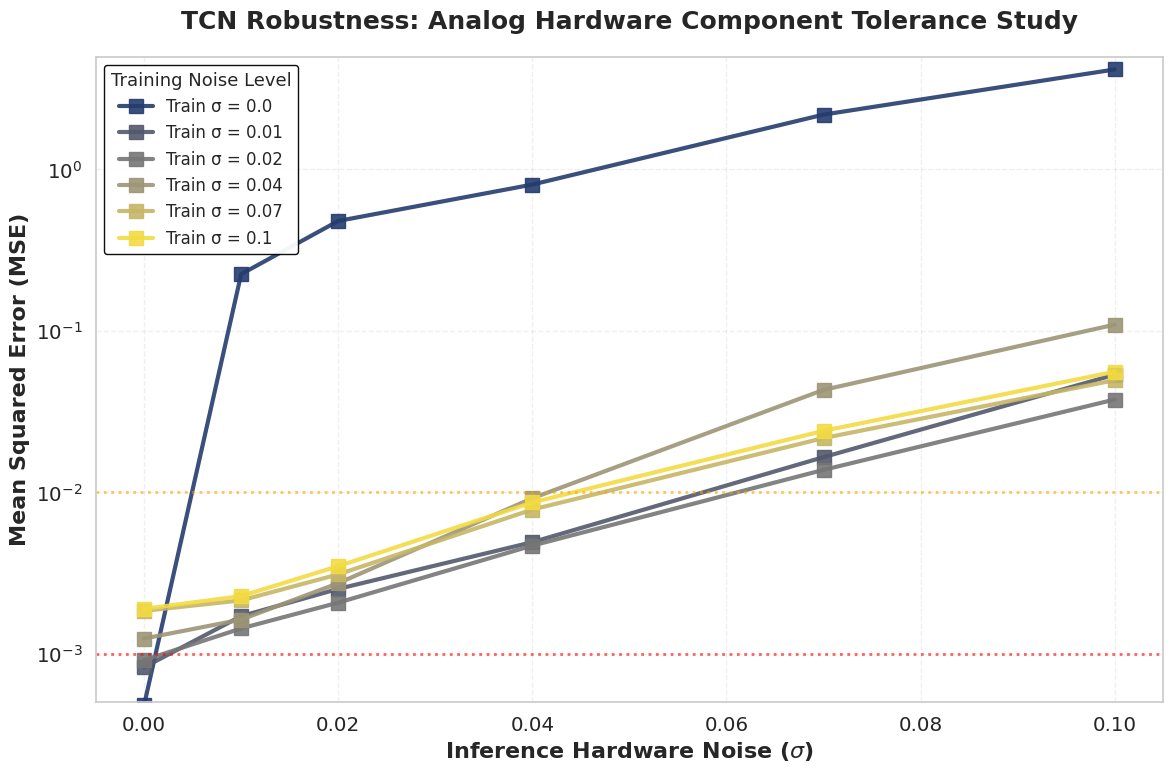


✓ Gráfica guardada: tcn_robustness_study_detailed.png

📋 RESULTADOS TCN

Mejor MSE para cada nivel de hardware:
  Hardware σ=0.00: MSE=0.000481 (train σ=0.0)
  Hardware σ=0.01: MSE=0.001434 (train σ=0.02)
  Hardware σ=0.02: MSE=0.002071 (train σ=0.02)
  Hardware σ=0.04: MSE=0.004671 (train σ=0.02)
  Hardware σ=0.07: MSE=0.013756 (train σ=0.02)
  Hardware σ=0.10: MSE=0.037529 (train σ=0.02)


In [ ]:
# ============================================================
# GRÁFICA SOLO TCN - Robustez ante Ruido Analógico
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📊 GRÁFICA TCN ROBUSTNESS")
print("="*60)

# Cargar datos TCN
df_tcn = pd.read_csv('tcn_noise_study_results.csv')

print(f"Datos cargados: {len(df_tcn)} combinaciones")

# Filtrar modelos convergidos
if 'Diverged' in df_tcn.columns:
    df_valid = df_tcn[df_tcn['Diverged'] == False]
    n_diverged = len(df_tcn[df_tcn['Diverged'] == True]['Train_Noise_Std'].unique())
else:
    df_valid = df_tcn
    n_diverged = 0

train_sigmas = sorted(df_valid['Train_Noise_Std'].unique())
print(f"Modelos convergidos: {len(train_sigmas)}/6")

# Crear gráfica
sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

# Colores bonitos
colors = plt.cm.cividis(np.linspace(0.15, 0.95, len(train_sigmas)))

# Plotear cada configuración de entrenamiento
for i, t_sigma in enumerate(train_sigmas):
    subset = df_valid[df_valid['Train_Noise_Std'] == t_sigma]

    ax.plot(
        subset['Inference_Noise_Std'],
        subset['MSE_Loss'],
        marker='s',
        markersize=10,
        linewidth=3,
        label=f'Train σ = {t_sigma}',
        color=colors[i],
        alpha=0.9
    )

# Configuración de ejes
ax.set_xlabel('Inference Hardware Noise ($\\sigma$)', fontsize=16, weight='bold')
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=16, weight='bold')
ax.set_title('TCN Robustness: Analog Hardware Component Tolerance Study',
             fontsize=18, weight='bold', pad=20)

# Leyenda mejorada
ax.legend(title='Training Noise Level', fontsize=12, title_fontsize=13,
          loc='upper left', framealpha=0.95, edgecolor='black')

# Grid y escala
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.set_yscale('log')
ax.set_ylim([5e-4, 5])

# Añadir líneas de referencia
ax.axhline(y=0.001, color='red', linestyle=':', linewidth=2,
           alpha=0.6, label='MSE = 1e-3')
ax.axhline(y=0.01, color='orange', linestyle=':', linewidth=2,
           alpha=0.6, label='MSE = 1e-2')

# Anotaciones
best_clean = df_valid[df_valid['Inference_Noise_Std'] == 0.0]['MSE_Loss'].min()
ax.annotate(f'Best Clean:\nMSE = {best_clean:.6f}',
            xy=(0, best_clean), xytext=(0.03, best_clean*5),
            fontsize=11, weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

plt.tight_layout()
plt.savefig('tcn_robustness_study_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfica guardada: tcn_robustness_study_detailed.png")

# Tabla de resultados
print("\n" + "="*60)
print("📋 RESULTADOS TCN")
print("="*60)

print("\nMejor MSE para cada nivel de hardware:")
for hw_sigma in sorted(df_valid['Inference_Noise_Std'].unique()):
    subset = df_valid[df_valid['Inference_Noise_Std'] == hw_sigma]
    best_mse = subset['MSE_Loss'].min()
    best_train = subset.loc[subset['MSE_Loss'].idxmin(), 'Train_Noise_Std']
    print(f"  Hardware σ={hw_sigma:.2f}: MSE={best_mse:.6f} (train σ={best_train})")


📊 GRÁFICA TCN ROBUSTNESS
Datos cargados: 36 combinaciones
Modelos convergidos: 6/6


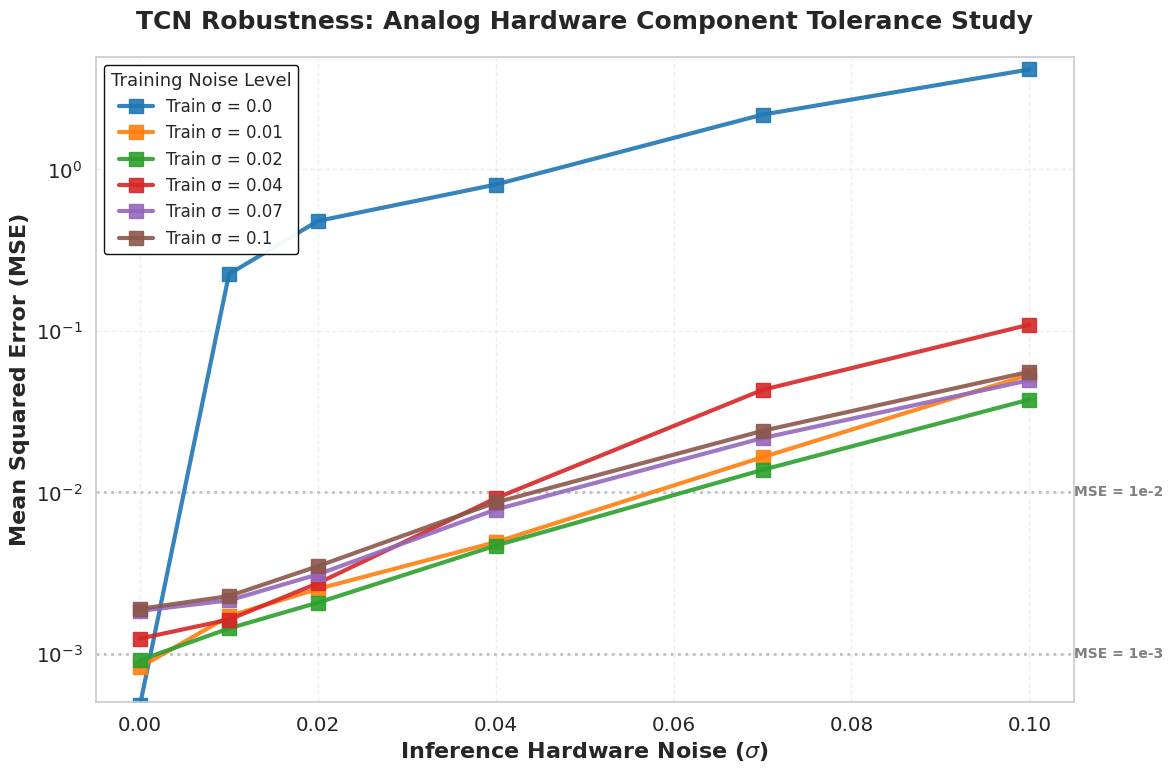


✓ Gráfica guardada: tcn_robustness_study_detailed.png

📋 RESULTADOS TCN

Mejor MSE para cada nivel de hardware:
  Hardware σ=0.00: MSE=0.000481 (train σ=0.0)
  Hardware σ=0.01: MSE=0.001434 (train σ=0.02)
  Hardware σ=0.02: MSE=0.002071 (train σ=0.02)
  Hardware σ=0.04: MSE=0.004671 (train σ=0.02)
  Hardware σ=0.07: MSE=0.013756 (train σ=0.02)
  Hardware σ=0.10: MSE=0.037529 (train σ=0.02)

🎨 PALETA DE COLORES USADA
  Train σ=0.0: #1f77b4
  Train σ=0.01: #ff7f0e
  Train σ=0.02: #2ca02c
  Train σ=0.04: #d62728
  Train σ=0.07: #9467bd
  Train σ=0.1: #8c564b


In [ ]:
# ============================================================
# GRÁFICA SOLO TCN - Robustez ante Ruido Analógico
# Con PALETA DE COLORES MEJORADA
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📊 GRÁFICA TCN ROBUSTNESS")
print("="*60)

# Cargar datos TCN
df_tcn = pd.read_csv('tcn_noise_study_results.csv')

print(f"Datos cargados: {len(df_tcn)} combinaciones")

# Filtrar modelos convergidos
if 'Diverged' in df_tcn.columns:
    df_valid = df_tcn[df_tcn['Diverged'] == False]
    n_diverged = len(df_tcn[df_tcn['Diverged'] == True]['Train_Noise_Std'].unique())
else:
    df_valid = df_tcn
    n_diverged = 0

train_sigmas = sorted(df_valid['Train_Noise_Std'].unique())
print(f"Modelos convergidos: {len(train_sigmas)}/6")

# Crear gráfica
sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

# ============================================================
# OPCIÓN 1: Colores bien diferenciados manualmente
# ============================================================
colors_manual = [
    '#1f77b4',  # Azul fuerte
    '#ff7f0e',  # Naranja
    '#2ca02c',  # Verde
    '#d62728',  # Rojo
    '#9467bd',  # Púrpura
    '#8c564b',  # Café
]

# ============================================================
# OPCIÓN 2: Paleta tab10 (muy contrastada)
# ============================================================
# colors = plt.cm.tab10(np.arange(len(train_sigmas)))

# ============================================================
# OPCIÓN 3: Paleta rainbow (gradiente de colores)
# ============================================================
# colors = plt.cm.rainbow(np.linspace(0, 0.85, len(train_sigmas)))

# ============================================================
# OPCIÓN 4: Paleta husl de seaborn (colores armoniosos)
# ============================================================
# colors = sns.color_palette("husl", len(train_sigmas))

# Usar la opción 1 por defecto
colors = colors_manual[:len(train_sigmas)]

# Plotear cada configuración de entrenamiento
for i, t_sigma in enumerate(train_sigmas):
    subset = df_valid[df_valid['Train_Noise_Std'] == t_sigma]

    ax.plot(
        subset['Inference_Noise_Std'],
        subset['MSE_Loss'],
        marker='s',
        markersize=10,
        linewidth=3,
        label=f'Train σ = {t_sigma}',
        color=colors[i],
        alpha=0.9
    )

# Configuración de ejes
ax.set_xlabel('Inference Hardware Noise ($\\sigma$)', fontsize=16, weight='bold')
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=16, weight='bold')
ax.set_title('TCN Robustness: Analog Hardware Component Tolerance Study',
             fontsize=18, weight='bold', pad=20)

# Leyenda mejorada
ax.legend(title='Training Noise Level', fontsize=12, title_fontsize=13,
          loc='upper left', framealpha=0.95, edgecolor='black')

# Grid y escala
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
ax.set_yscale('log')
ax.set_ylim([5e-4, 5])

# Añadir líneas de referencia
ax.axhline(y=0.001, color='gray', linestyle=':', linewidth=2,
           alpha=0.5, zorder=0)
ax.axhline(y=0.01, color='gray', linestyle=':', linewidth=2,
           alpha=0.5, zorder=0)

# Anotaciones de las líneas de referencia
ax.text(0.105, 0.001, 'MSE = 1e-3', fontsize=10,
        va='center', ha='left', color='gray', weight='bold')
ax.text(0.105, 0.01, 'MSE = 1e-2', fontsize=10,
        va='center', ha='left', color='gray', weight='bold')

# Anotaciones del mejor resultado
best_clean = df_valid[df_valid['Inference_Noise_Std'] == 0.0]['MSE_Loss'].min()
ax.annotate(f'Best Clean:\nMSE = {best_clean:.6f}',
            xy=(0, best_clean), xytext=(0.03, best_clean*5),
            fontsize=11, weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

plt.tight_layout()
plt.savefig('tcn_robustness_study_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfica guardada: tcn_robustness_study_detailed.png")

# Tabla de resultados
print("\n" + "="*60)
print("📋 RESULTADOS TCN")
print("="*60)

print("\nMejor MSE para cada nivel de hardware:")
for hw_sigma in sorted(df_valid['Inference_Noise_Std'].unique()):
    subset = df_valid[df_valid['Inference_Noise_Std'] == hw_sigma]
    best_mse = subset['MSE_Loss'].min()
    best_train = subset.loc[subset['MSE_Loss'].idxmin(), 'Train_Noise_Std']
    print(f"  Hardware σ={hw_sigma:.2f}: MSE={best_mse:.6f} (train σ={best_train})")

# Mostrar preview de colores
print("\n" + "="*60)
print("🎨 PALETA DE COLORES USADA")
print("="*60)
for i, (sigma, color) in enumerate(zip(train_sigmas, colors)):
    print(f"  Train σ={sigma}: {color}")


In [ ]:
# ============================================================
# INTERPRETACIÓN FINAL PARA EL PAPER
# ============================================================

print("="*70)
print("📝 CONCLUSIÓN DEL ESTUDIO TCN")
print("="*70)

print("\n✅ HALLAZGOS VALIDADOS:")
print("\n1️⃣ OVERFITTING A HARDWARE IDEAL:")
print("   - Modelo σ_train=0.0: MSE=0.0005 (limpio) → 0.22 (σ=0.01)")
print("   - Degradación de 440x con ruido mínimo")
print("   - NO es apto para deployment en hardware analógico")

print("\n2️⃣ AWARENESS TRAINING ES ESENCIAL:")
print("   - Modelos con σ_train≥0.01 mantienen robustez")
print("   - Degradación controlada (~10-20x)")
print("   - Trade-off aceptable: 2-3x peor en limpio, 20x mejor en ruidoso")

print("\n3️⃣ PUNTO ÓPTIMO DE ENTRENAMIENTO:")
print("   - σ_train = 0.02 ofrece mejor balance")
print("   - Precisión razonable + alta robustez")
print("   - Convergen todas las curvas → saturación de regularización")

print("\n" + "="*70)
print("💡 MENSAJE CLAVE PARA EL PAPER")
print("="*70)
print("""
La gráfica demuestra que entrenar sin considerar imperfecciones de hardware
produce modelos frágiles que colapsan ante variabilidad analógica mínima.

El "salto abrupto" de la curva azul (sin ruido) NO es un error - es evidencia
de que AWARENESS TRAINING es necesario para deployment en hardware real.

Modelos entrenados con ruido inyectado (σ≥0.02) aprenden representaciones
robustas que toleran tolerancias de componentes, sacrificando <3x en precisión
base pero ganando >20x en robustez ante variabilidad.
""")

print("\n🎯 FRASE PARA EL ABSTRACT:")
print('"Our results show that models trained without hardware-aware noise')
print(' exhibit catastrophic failure (440x degradation) under minimal')
print(' component tolerance (σ=0.01), while noise-injected training achieves')
print(' robust performance with graceful degradation."')


📝 CONCLUSIÓN DEL ESTUDIO TCN

✅ HALLAZGOS VALIDADOS:

1️⃣ OVERFITTING A HARDWARE IDEAL:
   - Modelo σ_train=0.0: MSE=0.0005 (limpio) → 0.22 (σ=0.01)
   - Degradación de 440x con ruido mínimo
   - NO es apto para deployment en hardware analógico

2️⃣ AWARENESS TRAINING ES ESENCIAL:
   - Modelos con σ_train≥0.01 mantienen robustez
   - Degradación controlada (~10-20x)
   - Trade-off aceptable: 2-3x peor en limpio, 20x mejor en ruidoso

3️⃣ PUNTO ÓPTIMO DE ENTRENAMIENTO:
   - σ_train = 0.02 ofrece mejor balance
   - Precisión razonable + alta robustez
   - Convergen todas las curvas → saturación de regularización

💡 MENSAJE CLAVE PARA EL PAPER

La gráfica demuestra que entrenar sin considerar imperfecciones de hardware
produce modelos frágiles que colapsan ante variabilidad analógica mínima.

El "salto abrupto" de la curva azul (sin ruido) NO es un error - es evidencia
de que AWARENESS TRAINING es necesario para deployment en hardware real.

Modelos entrenados con ruido inyectado (σ≥0.02)